# Chapter 4. Molecular Hamiltonians

In this section, we are going to discuss about applying VQE to find the lowest energy on a given complicating moleculars.

This chapter contains several topics

- Born-Oppenheimer approximation
- Fock space
- Fermionic creation and annihilation operators
- Molecular Hamiltonian in the Hatree-Fock orbitals basis
- Basis sets
- Constructing a fermionic Hamiltonian with Qiskit Nature
- Fermion to qubit mappings
- Constructing a qubit Hamiltonian operator with Qiskit Nature

## Installation

This part informs several python packages required for our tutorial.

In [36]:
!pip install numpy      # an open source Python library that is used in almost every field of science and engineering
!pip install qiskit     # an open source SDK for working with quantum computers at the level of pulses, circuits, and application modules
!pip install 'qiskit[visualization]'    # this is for qiskit visualization support
!pip install qiskit.utils               # updated qiskit
!pip install qiskit-nature              # a unique platform that bridges the gap between natural sciences and quantum simulations
!pip install pyscf                      # Python-based Simulations of Chemistry Framework, an open source collection of electronic structure modules powered by Python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user insta

In [37]:
#import packages
import numpy as np

#visualization tools
import matplotlib.pyplot as plt

#qiskit environments and Latex representations of complex array
from qiskit.visualization import array_to_latex, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit import execute, Aer
import qiskit.quantum_info as qi
from qiskit.quantum_info import SparsePauliOp   #updated qiskit
from qiskit.extensions import Initialize
#from qiskit.providers.aer import extensions     #import aer snapshot instructions

#qiskit nature libraries
from qiskit import Aer
#from qiskit_nature.drivers import UnitsType, Molecule

#from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
#from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
#from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
#from qiskit_nature.converters.second_quantization import QubitConverter

# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.second_q.operators import FermionicOp
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html#paulisumop-vs-sparsepauliop
from qiskit_nature import settings

#from qiskit_nature.operators.second_quantization import FermionicOp
#from qiskit_nature.circuit.library.initial_states import HartreeFock
#from qiskit_nature.circuit.library.ansatzes import UCCSD

#Qiskit Nature property framework
#from qiskit_nature.properties import Property, GroupedProperty
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
from qiskit_nature.second_q.operators import ElectronicIntegrals

#math libraries
import cmath
import math

## 4.1 Born-Oppenheimer Approximation

 Since the atomic orbital of an elebron in an atom and the molecular orbital of an electron in a molecule are time-independent stationary states, they can be solved by using time-independent Schr√∂dinger equation: $$ \hat{H} |\Psi \rangle = E | \Psi \rangle $$

 Where $\hat{H}$ is the non-relateve Hamiltonian operator obtained by quantizing the classical energy in Hamiltonian form (first quantization), and it represents the total energy($E$) of all its particles; $N$ electrons and $M$ nuclei.

 Let's define a system containing molecules on the coordinates. The origin of the coordinate system can be placed anywhere in free space. It is shown in the figure below

![Coordinate System with Molecules](./img/coordinates.png)

 The Molecular Hamiltonian in the coordinates is: $$ \hat{H} = -\sum_I \frac{\nabla_{R_I}^{2}}{M_I} -\sum_i \frac{\nabla_{r_i}^{2}}{m_e} -\sum_{I} \sum_{i} \frac{Z_I e^2}{|R_I - r_i|} + \sum_i \sum_{j > i} \frac{e^2}{|r_i - r_j|} + \sum_I \sum_{J > I} \frac{Z_I Z_J e^2}{|R_I - R_J|} $$

 where

- $\nabla_{r_i}^{2}$ and $\nabla_{R_I}^{2}$ are the second derivate operator with respecto to the position coordinates for electrons and nuclei, that is, $\nabla_{R_I}^{2} = \frac{\partial^2}{\partial_{x_I}^{2}} + \frac{\partial^2}{\partial_{y_I}^{2}} + \frac{\partial^2}{\partial_{z_I}^{2}}$ and likewise for the p<sup>th</sup> electrons.
- $r_{ij} = \left|r_i - r_j\right|, r_{iI} = \left|r_i - R_I\right|, R_{IJ} = \left|R_I - R_J\right|$ are the distances between electrons $i$ and $j$, electron $i$ and nucles $I$, and the nuclei $I$ and $J$ determined by the Eulidean norm
- indexes with upper case such as $I, J$ represent nuclei, and indexes with lower case such as $i, j$ represent electrons
- $Z_I$ represents the atomic number of the nuclei

 For clarity, we list the operators of the Molecular Hamiltonian in the table below:

| **Operator**                                            	| **Description**                                                                                                                                           	|
|---------------------------------------------------------	|-----------------------------------------------------------------------------------------------------------------------------------------------------------	|
| $\sum_{I} \frac{\nabla_{r_i}^{2}}{M_I}$                 	| Nuclear ***Kinetic*** Energy Operator                                                                                                                       	|
| $\sum_i \frac{\nabla_{r_i}^{2}}{m_e}$                  	| Electron ***Kinetic*** Energy Operator                                                                                                                      	|
| $\sum_{I} \sum_{i} \frac{Z_I e^2}{\|R_I - r_i\|}$      	| ***Potential*** Energy Operator arising from the interactions between the electrons and nuclei. It is the sum of all electron-nucleus Coulomb interactions. 	|
| $\sum_i \sum_{j > i} \frac{e^2}{\|r_i - r_j\|}$         	| ***Potential*** Energy Operator arising from electron-electron Coulomb repulsions                                                                           	|
| $\sum_I \sum_{J > I} \frac{Z_I Z_J e^2}{\|R_I - R_J\|}$ 	| ***Potential*** Energy Operator arising from nuclear-nuclear repulsion energy operator, the sum of all nucleus-nucleus Coulomb repulsions.                  	|

 In the **Born-Oppenheimer** approximation, we assume that the motions of the nuclie are uncoupled from the motions of the electrons, because the motions of the nuclei and those of the electrons are far different. To simplify, you can think that the position of nuclei are fixed(It is actually false because of the *uncertainty principle*, but it is just for the simplification). In the **Born-Oppenheimer** approximation, you solve for only the electronic equation with the fixed position of the nuclei. So, what we need to consider is just the motions of electrons. Let's define the hamiltonian related to the motions of electrons, which is only the deduction of only-nuclei-related-terms from the **Molecular Hamiltonian**: $$ \hat{H}_{el} = -\sum_{i} \frac{\nabla_{r_i}^{2}}{m_e} - \sum_{I} \sum_{i} \frac{Z_I}{|R_I - r_i|} + \sum_{i} \sum_{j > i} \frac{e^2}{|r_i - r_j|}$$

## 4.2. Fock space

 The electronic wave function $|\Psi\rangle_{elec}$ includes the spatial position for each electron ($r_P = \left\{x_p, y_p, z_p\right\}$) conditioned on the nuclear positions ($R_A = \left\{X_A, Y_A, Z_A\right\}$) and the spin directional coordinates for each electron ($s_p = \left\{s_{x_p}, s_{y_p}, s_{z_p}\right\}$). The electronic wave function must be antisymmetric with respect to the exchange of pair particle labels becuase these particles are fermions.

 The **Fock space** is the Hilbert space in which the *Slater determinant wave functions* , which is antisymmetric with respect to the eschange of two electrons or with respect to the exchange of two spin orbitals, belong. By definition, a Fock space is the sum of a set of Hilbert spaces representing at least 3 important configurations:

- The zero-particle state is interpreted as the **absence** of an electron in an orbital: $|0\rangle$
- One particle states are interpreted as: $|r_p, s_p\rangle$ or $|1\rangle$
- Two particles states are interpreted as: $|r_i, s_i, r_j, s_j \rangle = \frac{1}{\sqrt{2}} \left(|r_j, s_j\rangle \otimes |r_i, s_i \rangle - v|r_i, s_i \rangle \otimes |r_j, s_j \rangle \right)$ or $|11\rangle$

 Yes, this is only a mathematical construction and does not represent a physical reality or a chemical actuality. It can be seem useless, but the Fock space suggests the way to map the electron space of a molecule and the qubit space; but it is not a necessasry mapping. There are more computationally advantageous mapping methods and we will discuss about them later.

## 4.3. Fermionic Creation and Annihilation Operators

 We define a set of fermionic annihilation operators, $\left\{\hat{a}_i \right\}_{i = 0}^{N - 1}$ and creation operators, $\left\{\hat{a}_{i}^{\dagger} \right\}_{j = 0}^{N - 1}$, following anti-commutation relations: $$ \left\{\hat{a}_i, \hat{a}_{j}^{\dagger} \right\} = \hat{a}_{i}^{\dagger}\hat{a}_{j} + \hat{a}_{j}\hat{a}_{i}^{\dagger} = \delta_{ij} = \begin{cases} 0, i \neq j & \\ 1, i = j & \end{cases} \\ \left\{\hat{a}_{i}^{\dagger}, \hat{a}_{j}^{\dagger} \right\} = \left\{\hat{a}_i, \hat{a}_{j} \right\} = 0$$ where $\delta_{ij}$ is the Dirac delta function.

 A **fermionic operator** is a linear combination of products of **creation** and **annihilation operators**.

### 4.3.1. Fermion creation operator

 The fermionic creation operator $\hat{a}_{i}^{\dagger}$ raises by one unit number of particles sitting in the i<sup>th</sup> fermionic orbital: $$ \hat{a}_{i}^{\dagger} |\ldots m_i \ldots \rangle = \left(1 - m_i\right) (-1)^{\sum_{j < i} m_j} |\ldots (m + 1)_i \ldots \rangle $$ where:

- $m_i, (m+1)_i$ are the number of particles sitting in the i<sup>th<\sup> fermionic orbital
- $(1 - m_i)$ is a pre-factor that annihilates the state if we had an electron in the $i^{th}$ fermionic orbital, that is, if $m_i = 1$
- The phase factor $(-1)^{\sum_{j < i} m_j}$ keeps the anti-symmetric properties of the whole superposition of states.

### 4.3.2. Fermion annhilation operator

 The fermionic annhilation operator $\hat{a}_{i}^{\dagger}$ ,on the other hand, lowers by one unit number of particles sitting in the i<sup>th</sup> fermionic orbital: $$ \hat{a}_{i} |\ldots m_i \ldots \rangle = m_i (-1)^{\sum_{j < i} m_j} |\ldots (m - 1)_i \ldots \rangle $$ where:

- $m_i, (m-1)_i$ are the number of particles sitting in the $i^{th}$ fermionic orbital
- $m_i$ is a pre-factor that annihilates the state in the Slater determinant if there is no electron in the $i^{th}$ fermionic orbital, that is, if $m_i = 0$
- The phase factor $(-1)^{\sum_{j < i} m_j}$ keeps the anti-symmetric properties of the whole superposition of states.

## 4.4. Molecular Hamiltonian in the Hatree-Fock orbitals basis

 To map the original **electronic structure Hamiltonian** into the corresponding **qubit Hamiltonian**, we need to work in the second quantization formalism of quantum mechanics, which we have already introduced in the previous section, *Born-Oppenheimer approximation*

 The **Hatree-Fock (HF)** method approximates an N-body problem into N one-body problems where each electron evolves in the **mean field** of other electrons.

 Now, we can rewrite the electronic molecular Hamiltonian ($\hat{H}_{elec}$) as a linear combination of products of creation and annihilation operators: $$ \hat{H}_{elec} = \sum_{i, j} h_{pq} \hat{a}_{p}^{\dagger} \hat{a}_{q} + \frac{1}{2} \sum_{pqrs} h_{pqrs} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}$$

 where $\hat{a}_{p}$ removes an electron from spin-orbital $p$, and $\hat{a}_{q}^{\dagger}$ creates an electron in spin-orbital $q$ The operation $\hat{a}_{p}^{\dagger} \hat{a}_{q}$ is the **excitation operator** which excites an electron from the **occupied spin-orbital** into the **unoccupied orbital**. These mappings are summarized below:

| **Molecular Hamiltonian in the Born-Oppenheimer approximation** | **Linear combination of products of creation and annihilation operators**                                                          | **Description**                                                             |
|-----------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| $\sum_{i} \frac{\nabla_{r_i}^{2}}{m_e}$                         | $\frac{1}{m_e} \sum_{pq} \langle p \mid \nabla_{p}^{2} \mid j \rangle \hat{a}_{p}^{\dagger} \hat{a}_{q}$                           | Electronic kinetic energy operator                                          |
| $\sum_{I} \sum_{i} \frac{Z_I}{\mid R_I - r_i \mid}$             | $\sum_{pq} \langle p \mid \frac{Z_A}{r_{pq}} \mid q \rangle \hat{a}_{p}^{\dagger} \hat{a}_{q}$                                     | Potential energy between the electrons and nuclei.                          |
| $\sum_{i} \sum_{j > i} \frac{e^2}{\mid r_i - r_j \mid}$         | $\sum_{pqrs} \langle pq \mid \frac{1}{r_{pq}} \mid rs \rangle \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}$ | Potential energy operator arising from electron-electron Coulomb repulsions |

 So, we can define $h_{pq}$ and $h_{pqrs}$

 $$ h_{pq} = \langle p \mid \hat{h} \mid q \rangle = \int \phi_{p}^{*} (r) \left(-\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{\mid R_I - r \mid}\right) \phi_q (r) dr $$

 $$ h_{pqrs} = \langle pq \mid \hat{h} \mid rs \rangle = \int \frac{\phi_{p}^{\ast}(r_1) \phi_{q}^{\ast}(r_2) \phi_r(r_2) \phi_s(r_1)}{\mid r_1 - r_2 \mid} dr_1 dr_2 $$

## 4.5. Basis sets

### 4.5.1 Slater Type orbitals

 STO(Slater-Type Orbital)s have the same structure as the atomic orbitals of hydrogen-like systems and thier radial part have the following form: $$ R_l(r) = A(l, \alpha) r^l e^{-\alpha r} $$ where:

- $l$ is the angular momentum quantum with values ranging from 0 to $n - 1$, where $n$ is the principal quantum number
- $r$ is the nuclear distance of the elctron from the atomic nucleus
- $\alpha$ is called the orbital exponent and controls how fast the density of the orbital vanishes as a function of the nuclear distance

 $A(l, \alpha)$ is determined by the following normalization condition: $$\int_{0}^{\infty} \mid R_l(r) \mid^2 r^2 dr = 1 $$

 Noting that: $$\int_{0}^{\infty} x^l e^{-\alpha x} dx = \frac{l!}{\alpha^{l + 1}}$$

 Let's prove the equation above. Let's define $$I(\alpha) = \int_{0}^{\infty} e^{-\alpha x} dx = \frac{1}{\alpha}$$ assuming $I(\alpha)$ is a well-behaved function. Now, we are going to derivate both sides by $\alpha$: $$ \int_{0}^{\infty} (-x)^1 e^{-\alpha x} dx = (-1)(\alpha)^{-2}$$ now derivate once more: $$ \int_{0}^{\infty} (-x)^2 e^{-\alpha x} dx = (-1)^2 \times (2!) \times \alpha^{-3} $$ keep derivate: $$ \int_{0}^{\infty} (-x)^3 e^{-\alpha x} dx = (-1)^3 \times (3!) \times \alpha^{-3} $$ Can you see how it goes? We can figure out what's going to happen when it is derived $l$ times: $$ \int_{0}^{\infty} (-x)^l e^{-\alpha x} dx = (-1)^l \times (l!) \times \alpha^{-(l + 1)} $$ dividing both sides by $(-1)^l$ we get: $$ \int_{0}^{\infty} x^l e^{-\alpha x} dx = \frac{l!}{\alpha^{l + 1}} $$ Be aware that the method we just used only works on well-behave function.

 Back to normalization, we can compute $A(l, \alpha)$: $$ A(l, \alpha) = (2 \alpha)^{l + 1} \sqrt{\frac{2\alpha}{(2l + 2)!}} $$

 For $1s$ orbital, $l = 0$, hence $A(l, \alpha) = 2\alpha^{3/2}$ and the radial part of the Slater orbital is: $$R(r) = 2\alpha^{3/2} e ^{-\alpha r}$$

 Let's plot this function with the following Python code:

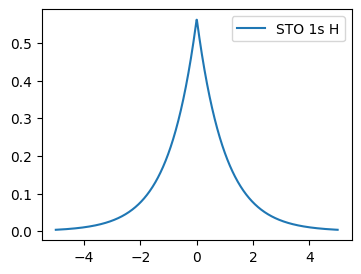

In [38]:
#### Plot 1s STO of H

x = np.linspace(-5,5,num=1000)
# we use absolute value because r is distance between electron and nuclear
r = abs(x)

# it is just experience value approximated when molecule is 1s H
alpha = 1.0

# radial part of the Slater orbital when molecule is 1s H
R = 1/np.sqrt(np.pi)*alpha**(1.5)*np.exp(-alpha*r)

plt.figure(figsize=(4,3))
plt.plot(x,R,label="STO 1s H")
plt.legend()

We plot the antisymmetric spatial wave function for the hydrogen molecule as a linear combination of the preceding radial part of the slater orbital for a hydrogen atom as follows:

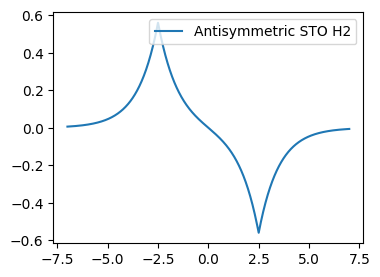

In [39]:
#### Plot 1s STO of H2

x = np.linspace(-7,7,num=1000)

r1 = abs(x+2.5)
r2 = abs(x-2.5)

alpha = 1.0

R = 1/np.sqrt(np.pi)*alpha**(1.5)*np.exp(-alpha*r1)-1/np.sqrt(np.pi)*alpha**(1.5)*np.exp(-alpha*r2)

plt.figure(figsize=(4,3))
plt.plot(x,R,label="Antisymmetric STO H2")
plt.legend()

### 4.5.2. Gaussian-type orbitals

 GTOs have the same angular form as STOs, but their radial function adopts a Gaussian form. By adopting the Gaussian form, they are easy to be computed. GTOs are given: $$ R_l(r) = B(l, \alpha) r^l e^{-\alpha r^2} $$ where:

- $l$ is the angular momentum quantum with values ranging from 0 to $ n - 1$, where n is the principal quantum number.
- $r$ is the nuclear distance of electron from the atomic nucleus
- $\alpha$ is called the orbital exponent and controls how fast the density of the orbital vanishes as a function of the nuclear distance.

 $B(l, \alpha)$ is determined by the following normalization condition: $$ \int_{0}^{\infty} \mid R_l(r) \mid^2 r^2 dr = 1 $$

 In practice, we approximate the radial part of an STO with a linear combination of primitive Gaussian functions, called a contracted Gaussian function. The STO-nG basis sets include one contracted Gaussian function per atomic orbital. $n$ is from 1 to 6, which indicates how many guassian functions are linearly combinated. For example, STO-2G consists of 2 primitive Gaussian functions, and STO-3G consists of 3 of them. In practice, we plot the STO-3G function for the $1s$ orbital of the hydrogen atom.

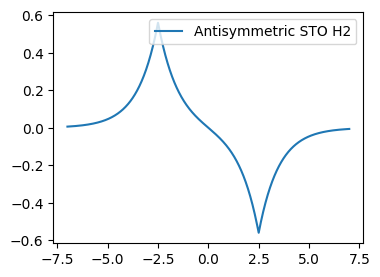

In [40]:
#### Plot 1s GTO of H

x = np.linspace(-7,7,num=1000)

r1 = abs(x+2.5)
r2 = abs(x-2.5)

alpha = 1.0

R = 1/np.sqrt(np.pi)*alpha**(1.5)*np.exp(-alpha*r1)-1/np.sqrt(np.pi)*alpha**(1.5)*np.exp(-alpha*r2)

plt.figure(figsize=(4,3))
plt.plot(x,R,label="Antisymmetric STO H2")
plt.legend()

 We plot the antisymmetric spatial wave function for the hydrogen molecule as a linear combination of the preceding radial part of the slater orbital for a hydrogen atom as follows:

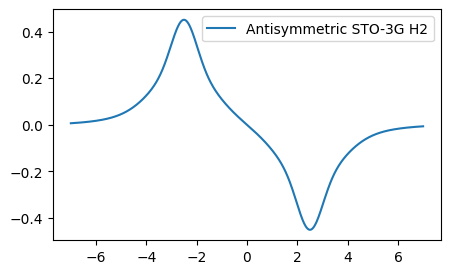

In [41]:
#### Plot 1s STO of H2

x = np.linspace(-7,7,num=1000)
r1 = abs(x+2.5)
r2 = abs(x-2.5)

c = [0.444635,0.535328,0.154329]
alpha = [0.109818,0.405771,2.227660]

psi = 0
for k in range(3):
  psi += c[k]*(2*alpha[k]/np.pi)**0.75 * np.exp(-alpha[k]*r1**2) \
  - c[k]*(2*alpha[k]/np.pi)**0.75 * np.exp(-alpha[k]*r2**2)

plt.figure(figsize=(5,3))
plt.plot(x,psi,label="Antisymmetric STO-3G H2")
plt.legend()

 we plot the STO, STO-2G, and STO-3G in 1s H together to visualize the difference between them

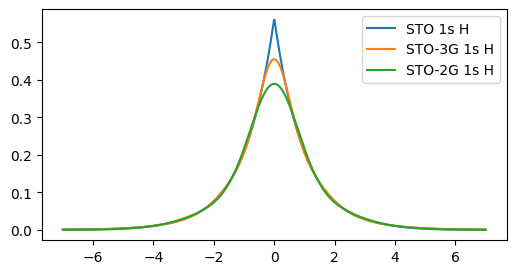

In [42]:
# compare STO and Gaussian

x = np.linspace(-7,7,num=1000)
r = abs(x)

# add STO, 2G, 3G c and aplpha
c_3G = [0.444635,0.535328,0.154329]
c_2G = [0.678914, 0.430129]
alpha_STO = 1
alpha_3G = [0.109818,0.405771,2.227660]
alpha_2G = [0.151623, 0.851819]

plt.figure(figsize=(6,3))

R_STO = 1/np.sqrt(np.pi) * alpha_STO**(1.5)*np.exp(-alpha_STO*r)

psi_3G = 0
psi_2G = 0
for k in range(3):
  gaussian = c_3G[k]*(2*alpha_3G[k]/np.pi)**0.75 * np.exp(-alpha_3G[k]*r**2)
  psi_3G += gaussian
for k in range(2):
  psi_2G += c_2G[k]*(2*alpha_2G[k]/np.pi)**0.75 * np.exp(-alpha_2G[k]*r**2)


plt.plot(x,R_STO,label="STO 1s H")
plt.plot(x,psi_3G,label="STO-3G 1s H")
plt.plot(x,psi_2G, label="STO-2G 1s H")
plt.legend()

## 4.6. Constructing a fermionic Hamiltonian with Qiskit Nature

Qiskit_nature package works with "spin orbital".

then, what is spin orbital?

each molecular orbirals(or spartial orbitals) can have spin-up electron or spin-down elctron. in perspective of molecular orbital, these state is in same states. but in perspective spin orbital, these state are different orbital. easily, for one molecular orbital, we have two spin orbitals. 

now we construct fermionic operator of hydrogen molecule with Qiskit nature

### 4.6.1. Constructing a fermionic Hamiltonian operator of the hydrogen molecule

#### the first things to do for constructing hamiltonian is define molecular geometry of hydrogen molecule with the Qiskit 'Moleculeinfo' class .'Moleculeinfo' class has the following input parameters
- Geometry : a list of atoms name and the cartesian coordinate of each atom (with angstrom units)
    atoms ÏôÄ, coords(Ï¢åÌëú) Îäî Î¶¨Ïä§Ìä∏Î°ú ÌååÎùºÎØ∏ÌÑ∞Î•º Î∞õÏúºÎ©∞, Îëê Î¶¨Ïä§Ìä∏ÏóêÏÑú Í∞ôÏùÄ Ïù∏Îç±Ïä§ Î≤àÌò∏ÎÅºÎ¶¨ Îß§Ïπ≠ÌïòÍ≤å ÎêúÎã§. 

    ÏòàÎ•º Îì§Ïñ¥ atoms Î•º Îã§ÏùåÍ≥ºÍ∞ôÏù¥ Ï†ïÏùòÌïúÎã§Í≥† ÌïòÍ≥†, -> ["A","B","C"] # Ïó¨Í∏∞ÏÑú A,B,C Îäî ÏõêÏûêÍ∏∞Ìò∏Ïù¥Îã§

    coords Î•º Îã§ÏùåÍ≥º Í∞ôÏù¥ Ï†ïÏùòÌïúÎã§Í≥† Ìï¥Î≥¥Ïûê. -> [(0,0,0), (x1,y1,z1), (x2,y2,z2)]

    Ïù¥Î†áÍ≤å Ï†ïÏùòÌïòÏòÄÏùÑÎïåÏùò Í∏∞ÌïòÌïôÏ†ÅÏù∏ Íµ¨Ï°∞Î•º ÎÇòÌÉÄÎÇ¥Î©¥ ÏïÑÎûòÏùò Í∑∏Î¶ºÍ≥º Í∞ôÎã§. 
   
   ![Coordinate with molecule](./img/moleculeinfo_coordinate.jpeg)
   
- charge : an integer, the electric charge of the molecule (if the molecule is electrically nature, this value should be 0)

- multiplicity : an integer, the multiplicity $ 2ùëÜ + 1 $ of the molecule, where $ùëÜ$ is the total spin angular momentum, which is determined by the number of unpaired electrons in the molecule, that is, the number of electrons that occupy a molecular orbital singly, not with another electron

    Ïù¥ Í∞úÎÖêÏùÄ ÏÇ¨Ïã§ ÏñëÏûêÏó≠ÌïôÏùÑ Î∞∞Ïö∞ÏßÄ ÏïäÏïòÎã§Î©¥ Ïù¥Ìï¥ÌïòÍ∏∞ ÌûòÎì† Í∞úÎÖêÏùº Ïàò ÏûàÎã§. ÌïòÏßÄÎßå Í∞ÑÎã®ÌïòÍ≤å ÏÑ§Î™ÖÌï¥Î≥¥Í≤†Îã§. 
    Ïò§ÎπÑÌÉà Í∞úÎÖêÏùÑ Î∞∞Ïö∏Îïå ÌõàÌä∏Ïùò Í∑úÏπôÏùÑ Îì§Ïñ¥Î≥¥ÏïòÏùÑ Í≤ÉÏù¥Îã§. Í∑∏ ÌõàÌä∏Ïùò Í∑úÏπô Ï§ë "ÌôëÏ†ÑÏûêÍ∞Ä Í∞ÄÏû• ÎßéÎèÑÎ°ù Î∞∞ÏπòÌïúÎã§. (Ïù¥Îïå Ï†ÑÏûêÏùò Î∞©Ìñ•ÏùÄ Î™®Îëê Í∞ôÎã§)" ÎùºÎäî Í≥†Îì±ÌïôÍµê ÌôîÌïôver Ïùò ÏÑ§Î™ÖÏùÑ Îì§Ïñ¥Î≥¥ÏïòÏùÑ Í≤ÉÏù¥Îã§. 

    Ïù¥Í±∞Îäî ÏÇ¨Ïã§ ÏàúÌôîÎêú Î≤ÑÏ†ÑÏù¥Í≥†, Îçî ÏóÑÎ∞ÄÌïú Î¨∏Ïû•ÏùÄ "Ïä§ÌïÄÏñëÏûêÏàò(S) Í∞Ä ÏµúÎåÄÍ∞Ä ÎêòÎèÑÎ°ù Ï†ÑÏûêÎäî Î∞∞ÏπòÎêúÎã§" Ïù¥Îã§. 

    Í∑∏Îüº Ïä§ÌïÄ ÏñëÏûêÏàòÎäî Î¨¥ÏóáÏù∏Í∞Ä ÌïòÎ©¥, Î∂ÑÏûêÏùò Î™®Îìú Ï†ÑÏûêÏùò Ïä§ÌïÄÏùò Ìï©Ïù¥Îã§. 

    Ïö∞Î¶¨Í∞Ä ÌùîÌûà Ïò§ÎπÑÌÉàÏù¥ÎùºÍ≥† Î∂ÄÎ•¥Îäî Spartial orbitalÏóêÎäî Ï†ÑÏûêÏùò Ïä§ÌïÄÏùÑ Í≥†Î†§ÌïòÏó¨ ÎëêÍ∞úÏùò Ï†ÑÏûêÍ∞Ä Ï∞®ÏßÄ Ìï† Ïàò ÏûàÎã§.

    Í∑∏Î¶¨Í≥† Ï†ÑÏûêÏùò Ïä§ÌïÄÏñëÏûêÏàòÎäî +1/2 , -1/2 ÏûÑÏùÑ ÏÉÅÍ∏∞ÌïòÎ©∞ ÏÉùÍ∞ÅÌïòÎ©¥, ÎëêÍ∞úÏùò Ï†ÑÏûêÎ°ú Ï∞®ÏûàÎäî Ïò§ÎπÑÌÉàÏóêÏÑúÎäî Ìïú Ïò§ÎπÑÌÉàÏóêÏÑú Ï†ÑÏûêÏùò Ïä§ÌïÄÏùò Ìï©Ïù¥ 0Ïù¥ÎêúÎã§. Í∑∏Î¶¨Í≥† ÎãπÏó∞Ìûà ÎπÑÏñ¥ÏûàÎäî Ïò§ÎπÑÌÉàÏóêÏÑúÎäî Ï†ÑÏûêÏùò Ïä§ÌïÄÏù¥ 0Ïù¥ÎêúÎã§. 

    Î¨∏Ï†úÍ∞Ä ÎêòÎäîÍ≤ÉÏùÄ ÌïòÎÇòÏùò Ï†ÑÏûêÎßå Í∞ÄÏßÄÍ≥† ÏûàÎäî Ïò§ÎπÑÌÉàÏù∏Îç∞, Í∑∏ Ïò§ÎπÑÌÉàÏóêÏÑ†Îäî Ï†ÑÏûêÏùò Î∞©Ìñ•Ïóê Îî∞Îùº +1/2 , - 1/2 Í∞Ä Îê† Ïàò ÏûàÎã§. 

    ÎëêÍ∞úÏùò Ïò§ÎπÑÌÉàÏù¥ ÌôëÏ†ÑÏûêÎ•º Í∞ÄÏßÑÎã§Í≥† Í∞ÄÏ†ïÌï¥Î≥¥Ïûê. Í∑∏Îïå, Îëê Ï†ÑÏûêÏùò Ïä§ÌïÄÎ∞©Ìñ•Ïù¥ Îã§Î•¥Í≤å(Î∞òÎåÄÎ°ú) Î∞∞ÏπòÌïòÎ©¥, Í∑∏ ÎëòÏùò Ïä§ÌïÄÍ∞ÅÏö¥ÎèôÎüâÏùÄ ÏÉÅÏáÑÎêòÏñ¥ Ï¥ù Ïä§ÌïÄÏñëÏûêÏàòÎäî 0Ïù¥Îê†Í≤ÉÏù¥Îã§. ÌòπÏùÄ, Îëê Ï†ÑÏûêÏùò Ïä§ÌïÄÎ∞©Ìñ•ÏùÑ Í∞ôÍ≤åÌïòÎ©¥, Ï¥ù Ïä§ÌïÄÏñëÏûêÏàòÎäî +1
    ÎòêÎäî -1Ïù¥ Îê†Í≤ÉÏù¥Îã§.
    Ïù¥Îïå ÌõàÌä∏Ïùò Í∑úÏπôÏùÑ ÏÉùÍ∞ÅÌï¥Î≥¥Î©¥, Ïù¥ Ïä§ÌïÄÏñëÏûêÏàòÍ∞Ä ÏµúÎåÄÍ∞Ä ÎêòÎäî Î∞©Î≤ï, Ï¶â ÎëêÍ∞úÏùò Ïä§ÌïÄÏù¥ +1/2 Î°ú Î∞∞ÏπòÎêòÎäî Í≤ΩÏö∞Í∞Ä ÏûêÏó∞Ï†ÅÏúºÎ°ú Ïò¨Î∞îÎ•∏ Î∞îÎã•ÏÉÅÌÉú ÎùºÍ≥† Ìï† Ïàò ÏûàÎã§. 

    Ïù¥Îü¨Ìïú Î∞©ÏãùÏúºÎ°ú, ÏûÑÏùòÏùò Î∂ÑÏûêÏóê ÎåÄÌï¥ Ïä§ÌïÄÏñëÏûêÏàòÎ•º Í≥ÑÏÇ∞Ìï¥Î≥º Ïàò ÏûàÍ≥†, Ïù¥ Í∞íÏùò ÎëêÎ∞∞Ïóê 1ÏùÑ ÎçîÌïúÍ∞íÏù¥ Î∞îÎ°ú ÏûêÏú†ÎèÑÏù¥Îã§. 

    #### Q. $H_2^+$ Ïùò ÏûêÏú†ÎèÑ(Ïä§ÌïÄ ÏñëÏûêÏàò)Î•º Íµ¨Ìï¥Î≥¥ÏÑ∏Ïöî. #ÎÇòÏ§ëÏóê ÏòàÏãúÏΩîÎìúÏóê ÎãµÏù¥ ÏûàÏäµÎãàÎã§.



#### ÏïÑÎûòÎäî $H_2$Ïóê ÎåÄÌï¥ Î∂ÑÏûêÍµ¨Ï°∞Ïùò Í∏∞ÌïòÍµ¨Ï°∞Î•º Î™®Îç∏ÎßÅ Ìïú ÏòàÏãúÏù¥Îã§.

In [43]:
H2_atoms = ["H", "H"]
H2_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)]
H2_charge = 0
H2_multiplicity = 1
H2_info_dict={'atoms':H2_atoms, 'coords':H2_coords, 'charge':H2_charge, 'multiplicity':H2_multiplicity}

H2_moleculeinfo = MoleculeInfo(H2_atoms, H2_coords, charge=H2_charge, multiplicity=H2_multiplicity)

Ïù¥Ï†ú basis setÏùÑ Í≤∞Ï†ïÌïòÍ≥†, PySCF ÌÅ¥ÎûòÏä§Î•º ÌÜµÌï¥ Î∂ÑÏûêÏùò Í∏∞ÌïòÌïôÏ†ÅÏù∏ Íµ¨Ï°∞Î•º Ïñ¥Îñ§ Ïö∞Î¶¨Í∞Ä ÌíÄÍ≥†ÏûêÌïòÎäî Î¨∏Ï†úÏÉÅÌô©ÏúºÎ°ú Î≥ÄÌôòÌï† Ïàò ÏûàÎã§. 

Ïó¨Í∏∞ÏÑúÎäî Î∂ÑÏûêÍµ¨Ï°∞Ïùò Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ ÎßåÎì§Í≤å ÎêúÎã§.

Ïö∞ÏÑ† PySCFDriver.from_molecule Ìï®ÏàòÎ•º ÌÜµÌï¥ Í∏∞ÌïòÌïôÏ†ÅÏù∏ Íµ¨Ï°∞Ïùò Driver ÎßåÎì§Í≤å ÎêúÎã§. Ïù¥ DriverÎäî Ïö∞Î¶¨Í∞Ä ÏÉùÍ∞ÅÌïòÎäî Í∏∞ÌïòÌïôÏ†ÅÏù∏ Íµ¨Ï°∞Î•º ÏÜåÌîÑÌä∏Ïõ®Ïñ¥Ï†ÅÏù∏ Îç∞Ïù¥ÌÑ∞Î°ú Î≥ÄÌôòÌïòÎäî Í≥ºÏ†ïÏù¥Îã§.

In [44]:
H2_driver = PySCFDriver.from_molecule(H2_moleculeinfo, basis="sto3g")

Ïù¥ ÎìúÎùºÏù¥Î≤Ñ(ÌïòÎìúÏõ®Ïñ¥ÏôÄ ÏÜåÌîÑÌä∏Ïõ®Ïñ¥Ïùò Ïó∞Í≤∞) ÏùÑ ÎßåÎì§ÏóàÏúºÎãà Ïù¥Ï†ú Ïù¥ Îç∞Ïù¥ÌÑ∞Î•º Í≥ÑÏÇ∞Ìï¥Ïïº Ìï†Í≤ÉÏù¥Îã§. 

Ïù¥ ÎèôÎÑ§ÏóêÏÑú Í∞ÄÏû• ÎßéÏù¥ ÏÇ¨Ïö©ÌïòÍ≤åÎêòÎäî HF Í≥ÑÏÇ∞ÏùÑ Ïã§ÌñâÌïòÎäîÍ≥ºÏ†ïÏù¥ ÏïÑÎûòÏùò ÏΩîÎìúÏù¥Í≥†, Ïù¥ ÎìúÎùºÏù¥Î≤ÑÎ•º Ïã§ÌñâÏãúÌÇ§Î©¥ Ï£ºÏñ¥ÏßÑ H2_moleculeinfo Ïóê ÎåÄÌïú Electrionic Structure Problem Ïóê ÎåÄÌïú ÌÅ¥ÎûòÏä§Î•º Î¶¨ÌÑ¥ÌïòÍ≤å Îê†Í≤ÉÏù¥Îã§. 

Electrionic Structure Problem ÏñòÎäî Ï£ºÏñ¥ÏßÑ Î∂ÑÏûêÍµ¨Ï°∞Ïóê Ìï¥ÎãπÌïòÎäî Ïó¨Îü¨ Î¨ºÎ¶¨ÎüâÎì§ Î≠ê, Ìó§Î∞ÄÌÜ†ÎãàÏïà, Ï†ÑÏûêÏàò, Ï†ÑÏûêÏùò Ïä§ÌïÄ Îì±ÏùÑ Í≥ÑÏÇ∞Ìï¥ÎëêÏñ¥ Ï†ÄÏû•ÌïòÎäî ÌÅ¥ÎûòÏä§Ïù¥Í≥†, 

Ïù¥Ìï¥ÌïòÍ∏∞ ÏâΩÍ≤åÎäî Ï£ºÏñ¥ÏßÑ Î∂ÑÏûêÍµ¨Ï°∞Ïóê ÎåÄÌï¥ ÌïÑÏöîÌïú Í∞ÑÎã®Ìïú Í≥ÑÏÇ∞Îì§ÏùÑ ÎØ∏Î¶¨ Ìï¥Îëî Ï†ïÎ≥¥Îì§ÏùÑ Ï†ÄÏû•Ìï¥Îëî Î≥¥Í¥ÄÏÜå ÎùºÍ≥† ÏÉùÍ∞ÅÌïòÎ©¥ ÎêúÎã§. 

ÏúÑÏùò Î∞©ÏãùÏúºÎ°ú Ïù¥Ìï¥Î•º ÌñàÎã§Î©¥ ÌÅ¥ÎûòÏä§ÏóêÏÑú Î©îÏÜåÎìúÎ•º ÌÜµÌï¥ Ï†ïÎ≥¥Î•º Î∂àÎü¨Ïò§Î©¥ ÎêòÍ≥†, ÏïÑÎûòÏùò Î∞©ÏãùÏúºÎ°ú Ïù¥Ìï¥Î•º ÌñàÎã§Î©¥, Ï£ºÏñ¥ÏßÑ ÏΩîÎìúÎ•º ÌÜµÌï¥ Î≥¥Í¥ÄÏÜåÏóêÏÑú ÌïÑÏöîÌïú Ï†ïÎ≥¥Î•º Í∫ºÎÇ¥Ïò®Îã§Í≥† ÏÉùÍ∞ÅÌïòÎ©¥ ÎêúÎã§. 

In [45]:
H2_problem = H2_driver.run()

ÎìúÎùºÏù¥Î≤ÑÎ•º Îü∞Ìï¥ÏÑú Ïù¥Ï†ú Ïö∞Î¶¨Í∞Ä ÏÇ¨Ï†ÑÏúºÎ°ú Ï§ÄÎπÑÌïòÍ≥†Ïûê ÌïòÎäîÍ≤ÉÏóêÍ±∞Ïùò Îã§ Ïò®Í≤ÉÏù¥Îã§. Ïö∞Î¶¨Í∞Ä Ïù¥ Ïó∞ÏÇ∞ÏóêÏÑú Í∞ÄÏû• ÌïÑÏöîÌïúÍ≤ÉÏùÄ "Ìó§Î∞ÄÌÜ†ÎãàÏïà"Ïù¥Îã§. Îî∞ÎùºÏÑú ÏïÑÎûòÏùò ÏΩîÎìúÎ•º ÌÜµÌï¥ Ï£ºÏñ¥ÏßÑ Î¨∏Ï†úÏóêÏÑú Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ Í∞ÄÏ†∏Ïò§Í≤åÎêúÎã§. 

In [46]:
H2_hamiltonian = H2_problem.hamiltonian

Í±∞Ïùò Îã§ ÏôîÎã§. Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ Íµ¨ÌñàÎäîÎç∞, Ïù¥Í±∞Î•º Ïö∞Î¶¨Îäî Ïä§ÌïÄÏò§ÎπÑÌÉàÏùÑ basisÎ°ú Í≥ÑÏÇ∞Ìï†Í±∞ÎãàÍπå, Ïù¥Î•º Ïä§ÌïÄÏò§ÎπÑÌÉàÏùÑ basisÎ°ú ÌïòÎäî ÌëúÌòÑÏúºÎ°ú Î∞îÍøîÏ£ºÏñ¥ÏïºÌïúÎã§. 

Ïä§ÌïÄÏò§ÎπÑÌÉàÏùÑ basisÎ°ú ÌëúÌòÑÌïòÍ∏∞ÏúÑÌï¥ Fermionic Ïó∞ÏÇ∞ÏûêÎ°ú Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ ÏπòÌôò(Îß§Ìïë) Ìï¥Ï£ºÏñ¥ÏïºÌïòÍ≥†, Ïù¥Î†áÍ≤å Ìï¥ÏÑú ÎßåÎì§Ïñ¥ÏßÑ Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ 2nd quantized HamiltonianÏù¥ÎùºÍ≥† Î∂ÄÎ•∏Îã§. 
-> Í∑∏ÎûòÏÑú Ïö∞Î¶¨Í∞Ä Ïì∏ ÌÅ¥ÎûòÏä§ÎèÑ Í∑∏ÏôÄ Í¥ÄÎ†®Îêú Ïù¥Î¶ÑÏù¥Îã§.

In [47]:
H2_second_q_op = H2_hamiltonian.second_q_op()
print(H2_second_q_op) #Ïù¥ ÏÖÄÏùÑ ÌÜµÌï¥ 2nd quantized HamiltonianÏùò ÌòïÌÉúÎ•º ÌôïÏù∏Ìï¥Î≥¥ÏÑ∏Ïöî(+ : Creation , - : annihilation)

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.2563390730032495 * ( +_0 -_0 )
+ -0.4718960072811421 * ( +_1 -_1 )
+ -1.2563390730032495 * ( +_2 -_2 )
+ -0.4718960072811421 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211565 * ( +_0 +_1 -_0 -_1 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211565 * ( +_0 +_3 -_2 -_1 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211572 * ( +_2 +_0 -_1 -_3 )
+ 0.09046

ÏúÑÏùò ÏãùÏùÑ Î≥¥Î©¥ Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÄ ÏïÑÎûòÏùò ÎëêÍ∞ÄÏßÄÏùò ÌòïÌÉúÎ•º Í∞ÄÏßÄÍ≤åÎêòÎäîÎç∞, Í∑∏ Í∞Å ÌòïÌÉúÏùò ÏùòÎØ∏Î•º ÏïåÏïÑÎ≥¥Ïûê. 
#### 1) single term

$\hat H_{pq} = h_{pq} a^\dagger_p a_q $--- single term hamiltonian

Ïù¥ Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÄ Í≤∞Íµ≠, Ïñ¥Îñ§ Î∂ÑÏûêÏùò ÌååÎèôÌï®ÏàòÏóê Í∞ÄÌï¥ÏßÄÍ≤å Îê†Í≤ÉÏù¥Í≥†, Í∏∞ÎåìÍ∞íÏùò Ï∏°Ï†ïÏùÑ ÌÜµÌï¥ Í∞Å ÏÉÅÌÉúÏùò ÏóêÎÑàÏßÄÏùò Í∏∞ÎåìÍ∞íÏùÑ Íµ¨ÌïòÍ≤å Îê† Í≤É Ïù¥Îã§.

Í∑∏Îüº Íµ¨ÌïòÎäî ÏóêÎÑàÏßÄÏùò "ÏÉÅÌÉú" Í∞Ä Ïñ¥Îñ§ Î¨ºÎ¶¨Ï†ÅÏù∏ ÏÉÅÌÉúÏù∏ÏßÄÎ•º Ïù¥Ìï¥Ìï¥Ïïº Ìï†Í≤ÉÏù¥Îã§.

ÏúÑÏùò ÏùºÎ∞òÌôîÎêú single termÏùÄ Ïñ¥Îñ§ Reference stateÎ•º ÎÇòÌÉÄÎÇ¥Îäî ÌååÎèôÌï®Ïàò(Ï†ïÌôïÌïòÍ≤åÎäî Î™®Î•¥ÏßÄÎßå sto-3g Í∞ôÏùÄ Î∞©ÏãùÏúºÎ°ú Í∑ºÏÇ¨Ìïú ÌååÎèôÌï®Ïàò)Ïùò Í∏∞ÎåìÍ∞íÏùÑ Ï∏°Ï†ïÌïòÍ≤å Îê† Í≤ÉÏù¥Îã§. Í∑∏Îüº ÏïÑÎûòÏùò ÏãùÏúºÎ°ú ÎÇòÌÉÄÎÇº Ïàò ÏûàÏùÑÍ≤ÉÏù¥Îã§. 
$$\langle \Psi \vert \hat H_{pq} \vert \Psi \rangle$$
Ïù¥Îäî ÏïûÏÑú Ï†ïÏùòÌïúÎåÄÎ°ú ÌëúÌòÑÌïòÎ©¥ ÏïÑÎûòÏôÄ Í∞ôÏù¥ ÌëúÌòÑ Ìï† Ïàò ÏûàÎã§. 
$$\langle \Psi \vert  h_{pq}  \hat a^\dagger_p  \hat a_q \vert \Psi \rangle$$

Ïù¥Îäî ÏÉùÏÑ±/ÏÜåÎ©∏ Ïó∞ÏÇ∞ÏûêÏùò Ï†ïÏùòÎåÄÎ°ú ÏÉùÍ∞ÅÌïòÍ≤åÎêòÎ©¥, ÏïÑÎûòÏôÄ Í∞ôÏù¥ Reference StateÏôÄ ÌïúÎ≤à Ïó¨Í∏∞Îêú ÏÉÅÌÉúÏùò ÎÇ¥Ï†ÅÏúºÎ°ú Ìï¥ÏÑù Ìï† Ïàò ÏûàÎã§. 
$$ h_{pq} \langle \Psi \vert \Psi^p_q \rangle$$

Ïù¥Îäî Slater-cordon ruleÏóê ÏùòÌïú Ï†ïÏùòÏóê Îî∞Î•¥Î©¥, (ÌòπÏùÄ ÏÜåÎ©∏Ïó∞ÏÇ∞ÏûêÎ•º $\langle \Psi \vert$ Ïóê Ï†ÅÏö©ÏãúÌÇ®Îã§Í≥† ÏÉùÍ∞ÅÌïòÎ©¥(Ïù¥ÎïåÎäî dual vectorÏù∏ ÏÉùÏÑ± Ïó∞ÏÇ∞ÏûêÎ°ú Î∞îÎÄåÍ≤å ÎêúÎã§.)
$$ h_{pq} \langle \Psi^q \vert \Psi^p \rangle$$

ÏôÄ Í∞ôÏù¥ Ìï¥ÏÑùÌï† Ïàò ÏûàÎã§. (Ïù¥Ìé∏Ïù¥ Ïù¥Ìï¥ÌïòÍ∏∞ Îçî ÏâΩÎã§.)
Ïä§ÌïÄÏò§ÎπÑÌÉàÏùò Í∞Å basisÎäî orthonormal ÌïòÎØÄÎ°ú, 
$$\delta_{pq}=1 $$
$$\therefore p=q$$

#### Ï¶â, Single term ÏóêÏÑú Í∞Å Ìï≠ÏùÄ Ï†ÑÏûêÍ∞Ä p(p=q) Ïò§ÎπÑÌÉàÏóê ÏûàÏùÑÎïåÏùò ÏóêÎÑàÏßÄÎ•º ÎÇòÌÉÄÎÇ¥Í≤å ÎêúÎã§.
Í∏∞ÎåìÍ∞íÏùÑ ÎØ∏Î¶¨ Í≥ÑÏÇ∞Ìï¥Î≥∏Îã§Î©¥, Í≥ÑÏÇ∞Í≤∞Í≥ºÎäî ÏïÑÎûòÏôÄ Í∞ôÎã§. 
$$\langle \Psi \vert \hat H_{pq} \vert \Psi \rangle = \sum_{i=0}^N h_{ii} (where, N :Ïä§ÌïÄÏò§ÎπÑÌÉà Ïàò-1)$$

#### 2) Double term 
double term ÎèÑ ÎßàÏ∞¨Í∞ÄÏßÄ Ïù¥Îã§. 

Í∏∞ÎåìÍ∞íÏùÑ Ï∏°Ï†ïÌïòÍ≤å ÎêòÎ©¥ ÏïÑÎûòÏôÄ Í∞ôÏùÑÍ≤ÉÏù¥Í≥†,
$$\langle \Psi \vert  h_{pqrs}  \hat a^\dagger_p \hat a^\dagger_q \hat a_r  \hat a_s \vert \Psi \rangle$$
ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú ÏïÑÎûòÏôÄÍ∞ôÏù¥ ÌëúÌòÑÌï† Ïàò ÏûàÍ≥†
$$h_{pqrs} \langle \Psi   \vert \Psi^{pq}_{sr} \rangle$$
Slater-cordon rule Î•º Ï†ÅÏö©ÌïòÎ©∞ ÏïÑÎûòÏôÄÍ∞ôÏù¥ ÌëúÌòÑÌï† Ïàò ÏûàÎã§. 
$$h_{pqrs} \langle \Psi^{sr}   \vert \Psi^{pq} \rangle$$

Ïù¥ÎïåÎèÑ ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú Ïä§ÌïÄÏò§ÎπÑÌÉà basisÎäî ÏÑúÎ°ú orthonormal ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê $p,q,r,s$ Îäî ÏïÑÎûòÏùò Í¥ÄÍ≥ÑÏãùÏùÑ ÎßåÏ°±ÌïúÎã§. 
$$\delta_{ps} = 1  , \delta_{qr} = 1 $$
$$\therefore p=s , q=r$$

Îî∞ÎùºÏÑú $p,q,r,s$ Ïóê ÎåÄÌïú Í∞Å Ìï≠Ïù¥ ÎÇòÌÉÄÎÇ¥Îäî Í≤ÉÏùÄ ÏïÑÎûòÏôÄ Í∞ôÎã§. 
$$h_{pqrs} \langle \Psi^{qp}   \vert \Psi^{qp} \rangle$$
Ï¶â, pÏò§ÎπÑÌÉàÏóê ÏûàÎäî Ï†ÑÏûêÏôÄ qÏò§ÎπÑÌÉàÏóê ÏûàÎäî Ï†ÑÏûêÍ∞ÑÏùò ÏÉÅÌò∏ÏûëÏö©Ïóê ÏùòÌïú ÏóêÎÑàÏßÄÎ•º ÏùòÎØ∏ÌïúÎã§. 

#### 3) Ïò§Ï∞®
1), 2) Îäî ÏÇ¨Ïã§ Ïù¥ÏÉÅÏ†ÅÏù∏ Í≤ΩÏö∞Ïù¥Îã§. 
spin orbitalÎ°ú ÌëúÌòÑÎêú Ïù¥ÏÉÅÏ†ÅÏù∏ ÌååÎèôÌï®ÏàòÎäî Ìó§Î∞ÄÌÜ†ÎãàÏïàÏóê ÎåÄÌï¥ orthonormal ÌïòÏßÄÎßå, 

Í∑∏ ÌååÎèôÌï®ÏàòÎäî Í≥ÑÏÇ∞Ïù¥ ÎÑàÎ¨¥ Î≥µÏû°ÌïòÏó¨, Ïö∞Î¶¨Îäî Slater orbitalÎ°ú Í∑ºÏÇ¨ÌïòÍ≥†, Í∑∏ Slater orbitalÏùÑ STO-3G Îì±Ïùò Î∞©ÏãùÏùÑ ÏÇ¨Ïö©Ìï¥ÏÑú ÌïúÎ≤à Îçî Í∑ºÏÇ¨Î•º ÌïòÍ≤åÎêúÎã§. 

Ïù¥Îü¨Ìïú Í∑ºÏÇ¨ÏóêÏùòÌï¥ Îã§Î•∏ Ïù∏Îç±Ïä§Ïóê ÎåÄÌï¥ÏÑúÎèÑ ÎÇ¥Ï†ÅÍ∞íÏù¥ 0Ïù¥ ÎêòÏßÄÏïäÍ≥†, Í∞íÏù¥ Ï°¥Ïû¨ÌïòÍ≤åÎêúÎã§.  

H2Ïùò Í≤ΩÏö∞Î•º ÏòàÎ°úÎì§Î©¥, 1) single termÏóê ÎåÄÌï¥ÏÑúÎäî orthonormality Í∞Ä Ïú†ÏßÄÍ∞Ä ÎêúÎã§. ÌïòÏßÄÎßå 2)double termÏóê ÎåÄÌï¥ÏÑúÎäî p=s , q=r Ïù¥ ÏïÑÎãåÍ≤ΩÏö∞ÎèÑ Í∞íÏù¥ Ï°¥Ïû¨ÌïòÍ≤åÎêúÎã§. 

Ïù¥Îü¨Ìïú Ïò§Ï∞®Îäî Î∂ÑÏûêÍ∞Ä Î≥µÏû°Ìï¥ÏßàÏàòÎ°ù Ïª§ÏßÄÍ≥†, ÎÇòÏ§ëÏóê Î≥¥Ïù¥Í≤†ÏßÄÎßå, LiH Ïùò Í≤ΩÏö∞ÏóêÎäî 1)Single term ÏóêÏÑúÎèÑ Ïù¥Îü¨Ìïú Ïò§Ï∞®Í∞Ä Î∞úÏÉùÌïòÍ≤åÎêúÎã§. 

Ìó§Î∞ÄÌÜ†ÎãàÏïàÏóêÏÑú Ïò§Ï∞®Î°ú Ïù∏Ìï¥ ÏÉùÍ∏∞Îäî Ìï≠Îì§Ïùò Í≥ÑÏàòÎäî Ï†ïÏÉÅÏ†ÅÏù∏ Í∞íÏóê ÎπÑÌï¥ ÏûëÏßÄÎßå, ÏñëÏûêÌöåÎ°ú Ï∞®ÏõêÏóêÏÑú ÌÅêÎπÑÌä∏Ïùò ÍπäÏù¥Ïóê ÎØ∏ÏπòÎäî ÏòÅÌñ•ÏùÄ Í∞ôÍ∏∞ÎïåÎ¨∏Ïóê, ÌöåÎ°úÏùò ÍπäÏù¥ Ï∏°Î©¥ÏóêÏÑú ÏÜêÌï¥Ïù¥Îã§. 

ÌòπÏùÄ ÏïÑÎûòÏôÄÍ∞ôÏù¥ ÌñâÎ†¨Ïùò ÌòïÌÉúÎ°úÎèÑ ÎÇòÌÉÄ ÎÇº Ïàò ÏûàÎã§.

Ïö∞Î¶¨Í∞Ä ÌíÄÏñ¥Ïïº ÌïòÎäîÍ±¥ 4Í∞úÏùò Ïä§ÌïÄÏò§ÎπÑÌÉà ÏãúÏä§ÌÖúÏù¥Í≥†, Í∞Å Ïä§ÌïÄÏò§ÎπÑÌÉàÏùÄ Ï†êÏú† ÎêòÏñ¥ÏûàÎÉê ÎêòÏñ¥ÏûàÏßÄ ÏïäÎÉê Î°ú ÏÉÅÌÉúÎ•º ÎÇòÎàå Ïàò ÏûàÍ≥†, Í∑∏ Ï†ïÎ≥¥Îäî ÏñëÏûêÏ†ÅÏù¥Îã§. 

Í∑∏ÎûòÏÑú Ïù¥ Í∞ÅÍ∞ÅÏùò Ïä§ÌïÄÏò§ÎπÑÌÉà ÏùÑ ÌÅêÎπÑÌä∏Î°ú ÎåÄÏπòÏãúÌÇ§Í≥†, Ïä§ÌïÄÏò§ÎπÑÌÉàÎ°ú Ïù¥Î£®Ïñ¥ÏßÑ Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ ÌÅêÎπÑÌä∏Ïùò Ïó∞ÏÇ∞Ïù∏ Í≤åÏù¥Ìä∏Î°ú ÏπòÌôòÏãúÌÇ§ÏûêÎäîÍ≤ÉÏù¥ Ïù¥ Î∂ÑÏûêÍµ¨Ï°∞ Î¨∏Ï†úÏùò ÌïµÏã¨ ÏïÑÏù¥ÎîîÏñ¥Ïù∏Îç∞, 

Ïù¥Îü¨Ìïú Ïó∞ÏÇ∞ÏùÑ Í∑∏ÎûòÏÑú ÏÉùÍ∞ÅÌï¥Î≥¥Í≤åÎêòÎ©¥, Í∞Å ÏÉÅÌÉú(ÌòπÏùÄ ÌÅêÎπÑÌä∏)Îäî 2x2 ÌñâÎ†¨Ïù¥Í≥†, Í∑∏ ÏÉÅÌÉúÍ∞Ä 4Í∞ú ÏûàÏúºÎØÄÎ°ú, Ï¥ù ÏÉÅÌÉúÎäî 16X16 ÌñâÎ†¨Ïù¥ ÎêòÍ≤å ÎêúÎã§.

Í∞Å Ïò§ÎπÑÌÉàÏùò Ï†êÏú†ÏÉÅÌÉúÎ•º $\vert 0000 \rangle $ , $\vert 0001 \rangle $, ... , $\vert 1111 \rangle $ Îì±Ïùò Fock basis Î°ú ÎÇòÌÉÄÎÇ¥Î©¥ ÌïòÎÇòÏùò ÏÉÅÌÉúÎäî 16X16Ïùò ÌñâÎ†¨ÏùÑ Ïù¥Î£®Í≤åÎêúÎã§. 


ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú, Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ Í∑∏Îü¨Ìïú ÌñâÎ†¨Ïùò Íº¥Î°ú ÎßûÏ∂∞ ÌëúÌòÑÌïúÍ≤ÉÏù¥ ÏïÑÎûòÏùò ÌòïÌÉúÏù¥Îã§. 

In [48]:
print(H2_second_q_op.to_matrix())

  (1, 1)	(-0.4718960072811421+0j)
  (2, 2)	(-1.2563390730032495+0j)
  (3, 3)	(-1.2445845498133268+0j)
  (4, 4)	(-0.4718960072811421+0j)
  (5, 5)	(-0.2452182918302661+0j)
  (10, 5)	(0.18093119978423144+0j)
  (6, 6)	(-1.0636533500290954+0j)
  (9, 6)	(0.1809311997842314+0j)
  (7, 7)	(-0.35332510410715434+0j)
  (8, 8)	(-1.2563390730032495+0j)
  (6, 9)	(0.1809311997842314+0j)
  (9, 9)	(-1.0636533500290954+0j)
  (5, 10)	(0.1809311997842313+0j)
  (10, 10)	(-1.8369679912029828+0j)
  (11, 11)	(-1.1606317377577635+0j)
  (12, 12)	(-1.2445845498133268+0j)
  (13, 13)	(-0.35332510410715423+0j)
  (14, 14)	(-1.1606317377577637+0j)
  (15, 15)	(0.21427823841947374+0j)


Ïù¥Ï†ú Ï£ºÏñ¥ÏßÑ Ï†ÑÏûêÍµ¨Ï°∞ Î¨∏Ï†úÏóê ÎåÄÌï¥ ÏûÖÏûêÏùò Ïàò(Ï†ÑÏûêÏùò Ïàò)Î•º ÏïåÏïÑÎ≥¥Ïûê. 

Î∞©Î≤ïÏùÄ ÏïÑÍπåÏôÄ Í∞ôÏù¥ ÌÅ¥ÎûòÏä§(Î≥¥Í¥ÄÏÜå) "H2_problem" ÏóêÏÑú Î©îÏÜåÎìúÎ•º ÌÜµÌï¥ Í∞ÄÏ†∏Ïò¨Í≤ÉÏù¥Îã§. 

In [49]:
num_spin_orbitals = H2_problem.num_spin_orbitals
num_particles = H2_problem.num_particles

print("num_particles = ",num_particles,"num_spin_orbitals = ", num_spin_orbitals)


'''
ÌòπÏùÄ Ïù¥Îü∞ÏãùÏúºÎ°ú Ìï®ÏàòÎ•º Ï†ïÏùòÌï¥ÏÑú ÏÇ¨Ïö©ÌïòÏÖîÎèÑ Ï¢ãÏäµÎãàÎã§
def get_particle_number(problem, show=True):
  
  # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.problems.ElectronicStructureProblem.num_spin_orbitals.html
  num_spin_orbitals = problem.num_spin_orbitals
  num_particles = problem.num_particles
  
  if show:
    print("Number of particles: {}".format(num_particles))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
    
  return num_particles, num_spin_orbitals
'''

num_particles =  (1, 1) num_spin_orbitals =  4


'\nÌòπÏùÄ Ïù¥Îü∞ÏãùÏúºÎ°ú Ìï®ÏàòÎ•º Ï†ïÏùòÌï¥ÏÑú ÏÇ¨Ïö©ÌïòÏÖîÎèÑ Ï¢ãÏäµÎãàÎã§\ndef get_particle_number(problem, show=True):\n  \n  # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.problems.ElectronicStructureProblem.num_spin_orbitals.html\n  num_spin_orbitals = problem.num_spin_orbitals\n  num_particles = problem.num_particles\n  \n  if show:\n    print("Number of particles: {}".format(num_particles))\n    print("Number of spin orbitals: {}".format(num_spin_orbitals))\n    \n  return num_particles, num_spin_orbitals\n'

#### ÏúÑÏùò ÏΩîÎìúÏóêÏÑú ÌîÑÎ¶∞Ìä∏Îêú Í≤∞Í≥ºÎ•º ÏÇ¥Ìé¥Î≥¥Ïûê. 

Ïä§ÌïÄÏò§ÎπÑÌÉà(num_spin_orbitals)Ïù¥ 4Í∞úÎùºÎäîÍ±∞Îäî Ïù¥Ìï¥Ìï† Ïàò ÏûàÏùÑÍ≤É Í∞ôÎã§. 

ÏàòÏÜåÏõêÏûê ÌïòÎÇòÏóê Ïä§ÌïÄÏò§ÎπÑÌÉàÏù¥ ÎëêÍ∞úÏù¥Í≥†, Ïö∞Î¶¨Í∞Ä Î≥¥Îäî H2 Î∂ÑÏûêÎäî Í∑∏ ÏàòÏÜåÏõêÏûêÍ∞Ä ÎëêÍ∞úÏûàÏúºÎãàÍπå Ïä§ÌïÄÏò§ÎπÑÌÉàÏù¥ Ï¥ù 4Í∞úÏù∏Í≤ÉÏùÄ ÎßêÏù¥ ÎêúÎã§. 

Í∑ºÎç∞ ÏïûÏóê ÏûÖÏûêÏàò (num_particles)Îäî Î¨¥Ïä®ÎúªÏùºÍπå.

Ïö∞Î¶¨Í∞Ä ÏïûÏÑú Ïä§ÌïÄ Í∞Å Ïö¥ÎèôÎüâÏù¥ +1/2 ÏùºÎïå up-spin Ï†ÑÏûêÎùºÍ≥† ÌïòÍ≥†, -1/2 ÏùºÎïå down-spin Ï†ÑÏûêÎùºÍ≥† ÌïúÎã§Í≥† ÏïΩÏÜçÏùÑ ÌïòÏòÄÎã§. Í∑ºÎç∞ Ïù¥ Hatree-Fock Í≥ÑÏÇ∞ÏùÑ ÌïòÎäî ÎèôÎÑ§ÏóêÏÑúÎäî Ï°∞Í∏à Îçî Ìé∏ÌïòÍ≤å Î∂ÄÎ•¥Í∏∞ ÏúÑÌï¥, up-spin ÏùÑ $\alpha$ Ï†ÑÏûê, down-spin ÏùÑ $\beta$ Ï†ÑÏûê ÎùºÍ≥† Î∂ÄÎ•∏Îã§. Í∑∏Î¶¨Í≥†, Ï†Ä (num_particles)ÏùÄ (H2_problem.num_alpha, H2_problem.num_beta) Ïùò ÌòïÌÉúÏù¥Îã§. Ï¶â, Ï†Ä ÌäúÌîåÏù¥ ÏùòÎØ∏ÌïòÎäî Í≤ÉÏùÄ ( ÏóÖÏä§ÌïÄ Ï†ÑÏûêÏàò, Îã§Ïö¥Ïä§ÌïÄ Ï†ÑÏûêÏàò) Ïù∏Í≤ÉÏù¥Îã§. 

ÏïÑÎûòÏùò ÏÑ∏Í∞ÄÏßÄÎ•º ÌîÑÎ¶∞Ìä∏Ìï¥ÏÑú ÏßÅÏ†ë ÌôïÏù∏Ìï¥Î≥¥ÎäîÍ≤ÉÏùÑ Ï∂îÏ≤úÌïúÎã§. 
- H2_problem.num_alpha
- H2_problem.num_beta
- H2_problem.num_particles

Ïù¥Ï†ú ÌïÑÏöîÌïú Í≥ÑÏÇ∞ÏùÑ ÎßàÏ≥§ÏúºÎãà ÏóêÎÑàÏßÄÎ•º Í≥ÑÏÇ∞Ìï¥Î≥ºÍπå? 

Ïù¥Ï†ú VQEÏùò ÏãúÏûëÏù∏Í∞Ä ÌïòÍ≤†ÏßÄÎßå, ÏÇ¨Ïã§ ÏïÑÍπå H2_problem Ïù¥ Ïö∞Î¶¨Í∞Ä ÌïÑÏöîÌïú Î¨ºÎ¶¨ÎüâÎì§ÏùÑ Îã§ Í≥ÑÏÇ∞Ìï¥Îëî Î≥¥Í¥ÄÏÜåÎùºÍ≥† ÌñàÎã§. 

Í∑∏ÎãàÍπå ÏóêÎÑàÏßÄÎèÑ ÏÇ¨Ïã§ Í≥ÑÏÇ∞ÎêòÏñ¥ÏûàÎã§. 

Í∑ºÎç∞ Ïö∞Î¶¨Í∞Ä Ìï¥ÏïºÌï†Í±∞Îäî Ïù¥ÌõÑ ÏßÑÌñâÌï† Ïö∞Î¶¨Ïùò VQE ÏïåÍ≥†Î¶¨Ï¶òÏù¥ ÏñºÎßàÎÇò Ïã§Ï†ú Í∞íÍ≥º ÎπÑÏä∑ÌïúÏßÄ ÏïåÏïÑÏïº ÎÇòÏ§ëÏóê Îçî Ïñ¥Î†§Ïö¥ Î∂ÑÏûêÏóêÏÑú Î†àÌçºÎü∞Ïä§ ÏóêÎÑàÏßÄÎ•º Íµ¨Ìï† Ïàò ÏóÜÎäî ÏÉÅÌô©ÏóêÏÑúÎèÑ, Ïö∞Î¶¨Ïùò VQE Í≥ÑÏÇ∞Í∞íÏù¥ ÎßûÎã§Îäî Í∑ºÍ±∞Î•º Í∞ÄÏßÄÍ≥† ÏïûÏúºÎ°ú ÎÇòÏïÑ Í∞à Ïàò ÏûàÏùÑÍ≤ÉÏù¥Îã§. 

Í∑∏ÎûòÏÑú Ï†ÑÎ∞òÏ†ÅÏù∏ ÏßÄÍ∏àÏùò Î™©Ï†ÅÏùÄ VQEÏùò Í≥ÑÏÇ∞Í∞íÍ≥º Î†àÌçºÎü∞Ïä§ ÏóêÎÑàÏßÄÎ•º ÎπÑÍµêÌï¥Î≥¥ÎäîÍ≤ÉÏù¥Îã§. 

ÏùºÎã® Î†àÌçºÎü∞Ïä§ ÏóêÎÑàÏßÄÎ•º H2_problem ÏúºÎ°úÎ∂ÄÌÑ∞ Í≥ÑÏÇ∞Ìï¥ÎëêÍ≥†, Ï†ÄÏû•Ìï¥ÎëêÏûê.

In [50]:
H2_reference_energy = H2_problem.reference_energy
print(H2_reference_energy)

-1.1169989967540035


### 4.6.2. Constructing a fermionic Hamiltonian operator of the lithium hydride molecule


ÏßÄÍ∏àÍπåÏßÄ H2Ïóê ÎåÄÌï¥ÏÑú Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ Íµ¨ÏÑ±ÌïòÎäî Î∞©Î≤ïÏùÑ Î∞∞Ïõ†Îã§. Ïù¥Ï†úÎäî LiH Î∂ÑÏûêÏóê ÎåÄÌï¥ÏÑú Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ Íµ¨Ìï¥Î≥º Í≤ÉÏù¥Îã§. 

ÏúÑ Î∞©Î≤ïÏùÑ Ïù¥Ìï¥ÌñàÎã§Î©¥, ÏïÑÎûòÏùò Í≥ÑÏÇ∞ÎèÑ ÏâΩÍ≤å Ìï† Ïàò ÏûàÏùÑÍ≤ÉÏù¥Îã§. 

In [51]:
#1 ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú Î∂ÑÏûêÏùò Íµ¨Ï°∞Î•º Ï†ÄÏû•ÌïúÎã§.

LiH_atoms = ["Li", "H"]
LiH_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 1.5474)]
LiH_charge = 0
LiH_multiplicity = 1
LiH_atom_pair=(1,0)
LiH_info_dict={'atoms':LiH_atoms, 'coords':LiH_coords, 'charge':LiH_charge, 'multiplicity':LiH_multiplicity, 'atom_pair':LiH_atom_pair}

LiH_moleculeinfo = MoleculeInfo(LiH_atoms, LiH_coords, charge=LiH_charge, multiplicity=LiH_multiplicity)

In [52]:
#2 Î∂ÑÏûêÏùò Íµ¨Ï°∞Î•º ÌÜµÌï¥ ÎìúÎùºÏù¥Î≤ÑÎ•º ÎßåÎì§Í≥†
#  ÎìúÎùºÏù¥Î≤ÑÎ•º Ïã§ÌñâÌïòÏó¨ Electronic Structure Problem ÌÅ¥ÎûòÏä§Î•º ÎßåÎì†Îã§.
LiH_driver = PySCFDriver.from_molecule(LiH_moleculeinfo, basis="sto3g")
LiH_problem = LiH_driver.run()
print (LiH_problem.num_spin_orbitals, LiH_problem.num_particles)

12 (2, 2)


Ïù¥Ï†ú LiH ÏóêÏÑúÎäî FreezeCoreTransformerÎ•º Ìï¥Ï§ÑÍ≤ÉÏù¥Îã§.

Ïù¥Í±∞Îäî Í≤∞Ìï©Ïóê Ï∞∏Ïó¨ÌïòÏßÄ ÏïäÎäî Ïò§ÎπÑÌÉàÏùÑ Ï†úÏô∏ÌïòÎäî Í≥ºÏ†ïÏù¥Îã§. 

LiHÏùò Í≤ΩÏö∞Î°ú ÏÑ§Î™ÖÌïòÍ≤å ÎêòÎ©¥ LiÏùò Í≤ΩÏö∞ (1s 2s)Î°ú Ï¥ù 4Í∞úÏùò spartial orbitalÏùÑ Í∞ÄÏßàÍ≤ÉÏù¥Í≥†, ÏàòÏÜåÏùò Í≤ΩÏö∞ (1s) Î°ú Ï¥ù 2Í∞úÏùò spartial orbitalÏùÑ Í∞ÄÏßàÍ≤ÉÏù¥Îã§.
Îî∞ÎùºÏÑú Ï¥ù 12Í∞úÏùò Ïä§ÌïÄÏò§ÎπÑÌÉàÏù¥ ÏûàÏùÑÍ≤ÉÏù¥Í≥†, 12Í∞úÍ∞Ä Î∞îÎ°ú ÏúÑÏùò ÏΩîÎìúÏóê ÎÇòÌÉÄÎÇòÏûàÎã§. 
Í∑ºÎç∞ Ïù¥Ï†ú Ïó¨Í∏∞ÏÑú Î∂ÑÏûêÍ≤∞Ìï©ÏùÑ ÏÉùÍ∞ÅÌïòÍ≥†, Í≤∞Ìï©Ïóê Ï∞∏Ïó¨ÌïòÏßÄ ÏïäÎäî Ïò§ÎπÑÌÉàÏùÑ ÎπºÎ≥¥Í≤åÎêòÎ©¥, Í≤∞Íµ≠ Î¶¨Ìä¨Ïùò ÏµúÏô∏Í≥Ω Ï†ÑÏûê 1Í∞úÏôÄ ÏàòÏÜåÏùò ÏµúÏô∏Í≥Ω Ï†ÑÏûê 1Í∞úÍ∞Ä Í≤∞Ìï©ÏùÑ ÌïòÍ≤åÎêòÎäî H2Ïùò Í≤ΩÏö∞ÏôÄ Í∞ôÍ≤åÎêúÎã§. 
Îî∞ÎùºÏÑú FreezeCoreTransformerÎ•º Í∞ÄÌïòÍ≤åÎêòÎ©¥, ÏïÑÎûòÏôÄÍ∞ôÏù¥ 4Í∞úÏùò Ïä§ÌïÄÏò§ÎπÑÌÉàÎßåÏù¥ ÎÇòÏò§Í≤åÎêúÎã§. 

In [53]:
transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])
LiH_problem = transformer.transform(LiH_problem)
print (LiH_problem.num_spin_orbitals, LiH_problem.num_particles)

6 (1, 1)


In [54]:
LiH_fermionic_hamiltonian = LiH_problem.hamiltonian
LiH_second_q_op = LiH_fermionic_hamiltonian.second_q_op()

In [55]:
print("Lithium hydride molecule, basis: sto3g, Hartree-Fock calculation")
print("Parameters freeze_core=True")
LiH_particle_number =LiH_problem.num_particles

Lithium hydride molecule, basis: sto3g, Hartree-Fock calculation
Parameters freeze_core=True


In [56]:
LiH_reference_energy = LiH_problem.reference_energy
print(LiH_reference_energy)

-7.863113882796406


In [57]:
# We print the first 20 terms of the fermionic Hamiltonian operator of the molecule
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
print("\n".join(str(LiH_second_q_op ).splitlines()[:22] + ["..."]))

Fermionic Operator
number spin orbitals=6, number terms=342
  -0.7806641137752635 * ( +_0 -_0 )
+ 0.04770212743625808 * ( +_0 -_1 )
+ -0.12958118796013018 * ( +_0 -_2 )
+ 0.04770212743625828 * ( +_1 -_0 )
+ -0.3590972946155381 * ( +_1 -_1 )
+ 0.06823802873504789 * ( +_1 -_2 )
+ -0.12958118796013013 * ( +_2 -_0 )
+ 0.06823802873504793 * ( +_2 -_1 )
+ -0.22617114856208465 * ( +_2 -_2 )
+ -0.7806641137752635 * ( +_3 -_3 )
+ 0.04770212743625808 * ( +_3 -_4 )
+ -0.12958118796013018 * ( +_3 -_5 )
+ 0.04770212743625828 * ( +_4 -_3 )
+ -0.3590972946155381 * ( +_4 -_4 )
+ 0.06823802873504789 * ( +_4 -_5 )
+ -0.12958118796013013 * ( +_5 -_3 )
+ 0.06823802873504793 * ( +_5 -_4 )
+ -0.22617114856208465 * ( +_5 -_5 )
+ 0.24548488034876564 * ( +_0 +_0 -_0 -_0 )
+ -0.02385105980699155 * ( +_0 +_0 -_0 -_1 )
...


In [58]:
print(LiH_second_q_op.to_matrix())

  (1, 1)	(-0.22617114856208465+0j)
  (2, 1)	(0.06823802873504789+0j)
  (4, 1)	(-0.12958118796013018+0j)
  (1, 2)	(0.06823802873504793+0j)
  (2, 2)	(-0.3590972946155381+0j)
  (4, 2)	(0.04770212743625808+0j)
  (3, 3)	(-0.3698582654236022+0j)
  (5, 3)	(0.03641071436289452+0j)
  (6, 3)	(0.14941663381648998+0j)
  (1, 4)	(-0.12958118796013013+0j)
  (2, 4)	(0.04770212743625828+0j)
  (4, 4)	(-0.7806641137752635+0j)
  (3, 5)	(0.03641071436289481+0j)
  (5, 5)	(-0.6744095751420309+0j)
  (6, 5)	(0.051117330409696654+0j)
  (3, 6)	(0.14941663381648992+0j)
  (5, 6)	(0.05111733040969673+0j)
  (6, 6)	(-0.9271642111544168+0j)
  (7, 7)	(-0.6054994947671638+0j)
  (8, 8)	(-0.22617114856208465+0j)
  (16, 8)	(0.06823802873504789+0j)
  (32, 8)	(-0.12958118796013018+0j)
  (9, 9)	(0.003031109256421194+0j)
  (10, 9)	(0.024426932936970173+0j)
  (12, 9)	(0.007977803851761278+0j)
  :	:
  (53, 54)	(0.03601000179255513+0j)
  (54, 54)	(-0.5746431507664239+0j)
  (31, 55)	(-0.1067745448649335+0j)
  (47, 55)	(-0.00780109

## 4.7. Fermion to qubit mapping

NÍ∞úÏùò ÌéòÎ•¥ÎØ∏Ïò®ÏúºÎ°ú Ïù¥Î£®Ïñ¥ÏßÑ ÏãúÏä§ÌÖúÏùÑ Í≥†Î†§Ìï†Îïå, Í∞Å ÌéòÎ•¥ÎØ∏Ïò®Îì§ÏùÑ 0Î∂ÄÌÑ∞ N-1 ÍπåÏßÄ Ïù∏Îç±Ïä§Î•º Ï§ÑÍ≤ÉÏù¥Îã§. 

Ïó¨Í∏∞ÏÑú Ïö∞Î¶¨Í∞Ä Ìï¥ÏïºÌï†Í≤ÉÏùÄ, Í∞Å ÌéòÎ•¥ÎØ∏Ïò® ÏÉÅÌÉúÎ•º ÌÅêÎπÑÌä∏ ÏÉÅÌÉúÎ°ú Îß§ÌïëÌï¥ÏïºÌïòÍ≥†, ÎòêÌïú Í∞Å ÌéòÎ•¥ÎØ∏Ïò® Ïó∞ÏÇ∞ÏûêÎ•º Î©ÄÌã∞ ÌÅêÎπÑÌä∏ Ïó∞ÏÇ∞ÏûêÎ°ú Îß§ÌïëÌïòÏó¨ÏïºÌïúÎã§(ÏÉùÏÑ±/ÏÜåÎ©∏ Ïó∞ÏÇ∞ÏûêÎ•º ÌÅêÎπÑÌä∏ Í≤åÏù¥Ìä∏Î°ú Îß§Ìïë)

Ïù¥ ÎèôÎÑ§ÏóêÏÑú Í∞ÄÏû• ÎßéÏù¥ Ïì∞Ïù¥ÎäîÍ≤ÉÏùÄ Jordan-Wigner Í≥º Bravyi-Kitaev Î≥ÄÌôòÏù¥ Í∞ÄÏû• ÎßéÏù¥ Ïì∞Ïù¥Í≥† Ïù¥Îäî Ï†ÑÏûêÏùò ÏàòÏôÄ ÎèôÏùºÌïú ÌÅêÎπÑÌä∏Í∞úÏàòÎßå ÌïÑÏöîÌïòÎã§Îäî Ïû•Ï†êÏù¥ ÏûàÎã§. 

### 4.7.1. Qubit creation and annihilation operators

Í∑∏Îüº ÌÅêÎπÑÌä∏Ï†ÅÏúºÎ°ú ÏÉùÏÑ±Í≥º ÏÜåÎ©∏ Ïó∞ÏÇ∞ÏûêÎ•º ÌëúÌòÑÌïòÎäî Î∞©Î≤ïÏùÑ Î∞∞ÏõåÎ≥¥Ïûê. 
ÏÉùÏÑ±Í≥º ÏÜåÎ©∏Ïù¥ÎùºÎäî Í≤ÉÏù¥ Î≠òÍπåÎ•º ÏÉùÍ∞ÅÌï¥Î≥¥Î©¥, 

$\vert 0 \rangle $ ÏÉÅÌÉúÎ•º $\vert 1 \rangle $ ÏÉÅÌÉúÎ°ú ÎßåÎìúÎäîÍ≤ÉÏù¥ ÏÉùÏÑ±Ïù¥Í≥†, 

$\vert 1 \rangle $ ÏÉÅÌÉúÎ•º $\vert 0 \rangle $ ÏÉÅÌÉúÎ°ú ÎßåÎìúÎäîÍ≤ÉÏù¥ ÏÜåÎ©∏Ïù¥Îã§. 

Í∑∏Î¶¨Í≥† ÏïûÏÑú Ï†ïÏùòÌïúÎåÄÎ°ú $\vert 0 \rangle $ ÏÉÅÌÉúÏóê ÏÜåÎ©∏Ïó∞ÏÇ∞ÏûêÎ•º Í∞ÄÌïòÎ©¥ 0Ïù¥Îê†Í≤ÉÏù¥Í≥†,

Í∑∏Î¶¨Í≥† $\vert 1 \rangle $ ÏÉÅÌÉúÏóê ÏÉùÏÑ±Ïó∞ÏÇ∞ÏûêÎ•º Í∞ÄÌïòÎ©¥ 0Ïù¥Îê†Í≤ÉÏù¥Îã§.

Ïö∞Î¶¨Í∞Ä Ï†ïÏùòÌïòÍ∏∞Î•º $\vert 0 \rangle = {1 \choose 0} $ , $\vert 1 \rangle = {0 \choose 1} $ ÎùºÍ≥† Ï†ïÏùòÌïòÏòÄÏúºÎØÄÎ°ú, ÌñâÎ†¨Ï†ÅÏù∏ Ïó∞ÏÇ∞ÏúºÎ°ú Ï†Ä ÎëêÏÉÅÌÉúÎ•º Î∞îÍæ∏Îäî ÏãùÏúºÎ°ú Íµ¨ÏÑ±ÏùÑ Ìï† Ïàò ÏûàÏùÑÍ≤É Í∞ôÎã§. 

Í∑∏Î†áÍ≤å  ÏïΩÏÜçÌïúÍ≤ÉÏù¥ ÏïÑÎûòÏùò Í∑∏Î¶ºÏù¥Îã§. 

![Qubit_creation:annihilation](./img/Qubit_creation:annihilation.png)

Ïù¥Ï≤òÎüº Ï†ïÏùòÌïòÍ≤åÎêòÎ©¥ ÏïÑÎûòÏôÄ Í∞ôÏù¥ Ïö∞Î¶¨Í∞Ä ÏïûÏÑú Ï†ïÏùòÌïú Ï†ïÏùòÎ•º ÎßåÏ°±ÌïúÎã§. (ÏïÑÎûò Í≥ÑÏÇ∞ÏùÄ ÏßÅÏ†ëÌïúÎ≤à Ìï¥Î≥¥ÎäîÍ≤ÉÏù¥ Ï¢ãÎã§.)

$\sigma^+\vert 0 \rangle  = \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 1 \\  0 \end{pmatrix} = \begin{pmatrix} 0 \\  1 \end{pmatrix} = \vert 1 \rangle  $

$\sigma^+\vert 1 \rangle  = \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 0 \\  1 \end{pmatrix} = 0 $

$\sigma^-\vert 0 \rangle  = \begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix} \begin{pmatrix} 1 \\  0 \end{pmatrix} = 0 $

$\sigma^-\vert 1 \rangle  = \begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix} \begin{pmatrix} 0 \\  1 \end{pmatrix} = \begin{pmatrix} 1 \\  0 \end{pmatrix} = \vert 0 \rangle  $

Í∑∏Î¶¨Í≥†, Ïù¥Îü¨Ìïú ÌÅêÎπÑÌä∏ ÏÉùÏÑ±/ÏÜåÎ©∏ Ïó∞ÏÇ∞ÏûêÎäî ÏïÑÎûòÏùò anti-commutation RelationÏùÑ ÎßåÏ°±ÌïúÎã§. 

$[\sigma^+,\sigma^-]= \mathbb{I} $


### 4.7.2. Jordan-Wigner transformation

Jordan-Wigner transformation ÏùÄ Í∞Å Ïä§ÌïÄÏò§ÎπÑÌÉàÏùò Ï†êÏú†ÏÉÅÌÉúÎ•º Í∞Å ÌÅêÎπÑÌä∏Ïóê Ï†ÄÏû•ÌïòÍ≤å ÎêúÎã§. 

Í∑∏Í±∏ Ïñ¥ÎñªÍ≤å ÌïòÎÇòÎ©¥, ÌéòÎ•¥ÎØ∏Ïò® ÏÉùÏÑ±/ÏÜåÎ©∏ Ïó∞ÏÇ∞ÏûêÎ•º ÌååÏö∏Î¶¨ Ïó∞ÏÇ∞ÏûêÏùò ÌÖêÏÑúÍ≥±ÏúºÎ°ú ÌëúÌòÑÌïúÎã§. 

$\sigma^+_k , \sigma^-_k $ Ïùò Ïó∞ÏÇ∞ÏûêÎäî kÎ≤àÏß∏ Ïò§ÎπÑÌÉàÏóê ÎåÄÏùëÎêòÎäî ÌÅêÎπÑÌä∏Ïóê Ï†êÏú†ÏÉÅÌÉúÎ•º Î∞îÍæ∏Í≤åÎêúÎã§. 

$\sigma_z$ Ïùò ÌÖêÏÑúÍ≥±ÏúºÎ°ú Ïù¥Î£®Ïñ¥ÏßÑ ÌååÏö∏Î¶¨ Ïó∞ÏÇ∞Ïûê $\sigma_z^{\otimes k}$ Îäî ÌéòÎ•¥ÎØ∏Ïò® Ïó∞ÏÇ∞ÏûêÍ∞Ä ÎßåÏ°±Ìï¥Ïïº Ìï† anti-commutation relationÏùÑ ÎßåÏ°±Ìï¥ÏïºÌïòÎäîÎç∞, Í∑∏Îü¨Í∏∞ÏúÑÌï¥ Ïó∞ÏÇ∞ÏûêÎ•º Í∞ÄÌï† kÎ≤àÏß∏ Ï†ÑÏóê Ïò§ÎπÑÌÉàÏóê ÎåÄÌï¥ +,- Ïùò ParityÎ•º Ï∂îÍ∞ÄÌïòÏó¨, Í∑∏ anti-Symmetry Î•º ÎßåÏ°±ÏãúÌÇ®Îã§.


ÏúÑ  ÌëúÏóêÏÑúÎäî ÌÅêÎπÑÌä∏Ïùò Ïù∏Îç±Ïä§Í∞Ä ÏïàÎã¨Î†§ ÏûàÏñ¥ÏÑú Ìó∑Í∞àÎ¶¨Í≤å ÌëúÌòÑÏù¥ ÎêòÏñ¥ÏûàÎã§. Îî∞ÎùºÏÑú Ìï¥ÏÑ§ÏùÑ Îã¨ÏûêÎ©¥

$\hat a_k^\dagger$ Ïóê ÎåÄÌï¥ ÏÉùÍ∞ÅÏùÑ Ìï¥Î≥¥Ïûê. 

Ïù¥Îäî k Î≤àÏß∏ "Ïò§ÎπÑÌÉà"Ïóê ÏÉùÏÑ± Ïó∞ÏÇ∞Ïûê, Ï¶â Ï†ÑÏûê ÌïòÎÇòÎ•º Ï∂îÍ∞ÄÌïòÎäî Ïó∞ÏÇ∞Ïù¥Îã§. 

Ïö∞Î¶¨Îäî Ïù¥Í±∞Î•º TransformÏùÑ ÌÜµÌï¥ ÌÅêÎπÑÌä∏ÏôÄ Í¥ÄÎ†®Îêú Ïó∞ÏÇ∞ÏúºÎ°ú Î∞îÍæ∏Í≥† Ïã∂Îã§. Ï¶â Ïó¨Í∏∞ÏÑúÎäî Í∞ÅÍ∞ÅÏùò Ïò§ÎπÑÌÉàÏùÑ ÌÅêÎπÑÌä∏Î°ú Îß§ÌïëÌïòÍ≤åÎêúÎã§. 

Í∑∏ÎûòÏÑú ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú k Î≤àÏß∏ ÌÅêÎπÑÌä∏Ïóê Ìï¥ÎãπÌïòÎäî Ïó∞ÏÇ∞ÏùÄ ÌÅêÎπÑÌä∏ Î≤ÑÏ†ÑÏùò ÏÉùÏÑ± Ïó∞ÏÇ∞Ïûê $\sigma_k$ Í∞Ä Í±∏Î¶¨Í≤å ÎêúÎã§. 

Ïó¨Í∏∞ÏÑú Ïù¥Ï†ú ÏïÑÍπå ÎßêÌñàÎçò parityÎ•º Ï∂îÍ∞ÄÌï†Í≤ÉÏù¥Îã§. 

kÎ≤àÏß∏ ÌÅêÎπÑÌä∏Í∞Ä ÏûàÏúºÎ©¥, Í∑∏ Ï†ÑÏùò k-1Î≤àÏß∏, k-2Î≤àÏß∏, ..., 0Î≤àÏß∏ ÌÅêÎπÑÌä∏Í∞Ä ÏûàÏùÑÍ≤ÉÏù¥Îã§. Í∑∏ ÌÅêÎπÑÌä∏ÏóêÎäî Î™®Îëê Z Ïó∞ÏÇ∞ÏûêÎ•º Í∞ÄÌïúÎã§. Ïù¥Îäî ÏïûÏÑúÎèÑ ÏÑ§Î™ÖÌïòÏòÄÏßÄÎßå, ÏÉùÏÑ± Ïó∞ÏÇ∞ÏûêÍ∞Ä Í∞ÄÏßÄÍ≥† ÏûàÏñ¥ÏïºÌï† Î∞òÎåÄÏπ≠ÏùÑ ÎßåÏ°±ÌïòÍ∏∞ ÏúÑÌïú Ìï≠ Ïù¥Îã§. 

Í∑∏Î¶¨Í≥† kÎ≤àÏß∏ ÌÅêÎπÑÌä∏ Ïù¥ÌõÑÏùò ÌÅêÎπÑÌä∏, Ï¶â k+1, k+2, ... N(Ïó¨Í∏∞ÏÑú NÏùÄ Ï¥ù ÌÅêÎπÑÌä∏ Í∞úÏàò, ÏòàÎ•ºÎì§Ïñ¥ 4ÌÅêÎπÑÌä∏ ÏãúÏä§ÌÖúÏóêÏÑú N=4)ÏóêÎäî Îã®ÏúÑÌñâÎ†¨, Ï¶â ÏïÑÎ¨¥ Ïó∞ÏÇ∞ÎèÑ Ïïà ÌïòÍ≤åÎêúÎã§. 

Ïù¥ ÌíÄÏù¥Î•º Í∑∏ÎåÄÎ°ú ÏãùÏúºÎ°ú ÏòÆÍ∏∞Í≤åÎêòÎ©¥, ÏïÑÎûòÏôÄ Í∞ôÎã§. 

$$ Z_0 \otimes Z_1 \otimes ... \otimes Z_{k-1} \otimes \sigma^+_k \otimes \mathbb{I}_{k+1} \otimes \mathbb{I}_{k+2} \otimes ...\otimes \mathbb{I}_{N}$$

Ïó¨Í∏∞ÏÑú \sigma^+_k Î•º ÌååÏö∏Î¶¨Ïó∞ÏÇ∞ÏûêÎ°ú ÌëúÌòÑÌïòÍ≤åÎêòÎ©¥, $1/2 (X-iY)$ Ïù¥ÎØÄÎ°ú ÌååÏö∏Î¶¨ Ïó∞ÏÇ∞ÏûêÏùò ÌÖêÏÑúÍ≥±ÏúºÎ°ú ÌëúÌòÑÌïòÎ†§Í≥†ÌñàÎçò Ï¥àÍ∏∞ Î™©Ï†ÅÎåÄÎ°ú ÌëúÌòÑÌïòÍ≤å ÎêòÎ©¥ ÏïÑÎûòÏôÄ Í∞ôÎã§. 

$$1/2  Z_0 \otimes Z_1 \otimes ... \otimes Z_{k-1} \otimes (X_k -iY_k) \otimes \mathbb{I}_{k+1} \otimes \mathbb{I}_{k+2} \otimes ...\otimes \mathbb{I}_{N}$$

Ïù¥ Í≤∞Í≥ºÎ•º Î≥¥Í≤åÎêòÎ©¥, ÌïòÎÇòÏùò Fermionic Ïó∞ÏÇ∞ÏûêÎ•º Îß§ÌïëÌï†Îïå, ÌÅêÎπÑÌä∏Ïùò Í∞úÏàòÎßåÌÅºÏùò Ìï≠Ïù¥ ÌïÑÏöîÌïòÍ≤åÎêúÎã§. Ïù¥Îäî ÎßåÏïΩ nÍ∞úÏùò Ïó∞ÏÇ∞ÏûêÍ∞Ä ÏûàÎã§Î©¥ NnÍ∞úÏùò ÌååÏö∏Î¶¨ Ïó∞ÏÇ∞ÏûêÍ∞Ä ÌïÑÏöîÌï†Í≤ÉÏù¥Îã§. 

Îî∞ÎùºÏÑú JW Î≥ÄÌôòÏùÄ, ÌÅêÎπÑÌä∏Ïùò Í∞úÏàòÏóê ÎåÄÌï¥ ÏÑ†ÌòïÏ†ÅÏù¥Îã§ $(=O (N))$

Í∑∏Îüº Ïù¥Ï†ú Ïù¥Îü¨Ìïú Î≥ÄÌôòÏùÑ ÏßÅÏ†ë ÏΩîÎìúÎ•º ÌÜµÌï¥ ÌôïÏù∏Ìï¥Î≥¥Ïûê.

In [59]:
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html#paulisumop-vs-sparsepauliop
settings.use_pauli_sum_op = False

# https://qiskit.org/documentation/nature/locale/bn_BN/stubs/qiskit_nature.second_q.operators.FermionicOp.html
# A FermionicOp is initialized with a dictionary, mapping terms to their respective coefficients

def label_to_qubit(label, mapper):
    f_op = FermionicOp(label)
    qubit_op = mapper.map(f_op)
    return qubit_op
#fermionic_label = ["+_0", "+_1", "+_2", "+_3", "+_4"]

for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, {"+_4":1.0}):
  qubit_op = label_to_qubit(k, JordanWignerMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZZ', 'YZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZZZ', 'YZZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_4': 1.0}:
 SparsePauliOp(['XZZZZ', 'YZZZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])



ÏúÑÏóêÏÑú ÏàòÏãùÏúºÎ°ú Î≥¥ÏïòÎçòÍ≤É Ï≤òÎüº, ÏòàÎ•ºÎì§Ïñ¥ $\hat a ^\dagger_3$ Ïù¥ JWÎ≥ÄÌôòÎêú Í≤∞Í≥ºÎ•º Î≥¥Î©¥, 

0,1,2 Î≤àÏß∏ ÌÅêÎπÑÌä∏ÏóêÎäî ZÏó∞ÏÇ∞ÏûêÍ∞Ä Í∞ÄÌï¥ÏßÄÍ≥†, 3Î≤àÏß∏ ÌÅêÎπÑÌä∏ ÏóêÎäî $1/2 (X-iY)$ Í∞Ä Í∞ÄÌï¥ÏßÄÎäîÍ≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§. 

### 4.7.3. Parity transformation

Parity Î≥ÄÌôòÏùÄ JWÎ≥ÄÌôòÍ≥º ÎåÄÏùëÎêòÎäî Îã§Î•∏ Î≥ÄÌôòÏù¥Îã§. 

Parity Î≥ÄÌôòÏùÄ Parity Ïó∞ÏÇ∞ÏûêÏóêÎäî ÎÇÆÏùÄ Í∞ÄÏ§ëÏπòÎ•º Î∂ÄÏó¨ÌïòÍ≥†, Ï†êÏú†ÏÉÅÌÉúÎ•º ÎÇòÌÉÄÎÇ¥Îäî Ïó∞ÏÇ∞ÏûêÏóêÎäî ÎÜíÏùÄ Í∞ÄÏ§ëÏπòÎ•º Î∂ÄÏó¨ÌïúÎã§. 

ÏàòÌïôÏ†ÅÏù¥ Îß§Ìïë Î∞©Î≤ïÏùÄ ÏïÑÎûòÏùò Í∑∏Î¶ºÍ≥º Í∞ôÎã§. 

![Coordinate System with Molecules](./img/Parity.png)

ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú Ìï≠Ïóê ÎåÄÌï¥ ÏÑ§Î™ÖÏùÑ ÌïòÏûêÎ©¥, 

JW ÏôÄ ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú k Î≤àÏß∏ ÌÅêÎπÑÌä∏Ïóê Ìï¥ÎãπÌïòÎäî Ïó∞ÏÇ∞ÏùÄ ÌÅêÎπÑÌä∏ Î≤ÑÏ†ÑÏùò ÏÉùÏÑ± Ïó∞ÏÇ∞Ïûê $\sigma_k (=X_k\pm iY_k) $Í∞Ä Í±∏Î¶¨Í≤å ÎêúÎã§.

ÌïòÏßÄÎßå ParityÎ•º Ï∂îÍ∞ÄÌïòÎäî Î∂ÄÎ∂ÑÏù¥ Î∞òÎåÄÏù¥Îã§. 

kÎ≥¥Îã§ ÏûëÏùÄ Ïù∏Îç±Ïä§Ïóê ÎåÄÌï¥ÏÑúÎäî XÏò§ÌçºÎ†àÏù¥ÌÑ∞ÏóêÏÑúÎäî k-1Î≤àÏß∏ÏóêÎßå ZÏò§ÌçºÎ†àÏù¥ÌÑ∞Í∞Ä Î∂ôÍ≥†, k-2,k-3,...,0 Î≤àÏß∏ ÌÅêÎπÑÌä∏Îäî I Ïó∞ÏÇ∞ÏûêÍ∞Ä Í∞ÄÌï¥ÏßÑÎã§, 
                      YÏò§ÌçºÎ†àÏù¥ÌÑ∞ Î∂ÄÎ∂ÑÏóêÎäî k-1, k-2,..., 0 Î≤àÏß∏ ÌÅêÎπÑÌä∏ Î™®Îëê I Ïó∞ÏÇ∞ÏûêÍ∞Ä Í∞ÄÌï¥ÏßÑÎã§, 

kÎ≥¥Îã§ ÌÅ∞ Ïù∏Îç±Ïä§Ïóê ÎåÄÌï¥ÏÑúÎäî XÏò§ÌçºÎ†àÏù¥ÌÑ∞Í∞Ä Í∞ÄÌï¥ÏßÄÍ≤åÎêúÎã§.Ï¶â, kÎ≤àÏß∏ Ïò§ÎπÑÌÉàÏóê ÏÉùÏÑ±Ïù¥ Í∞ÄÌï¥ÏßÄÎäî Ïó∞ÏÇ∞ÏûêÏùò Í≤ΩÏö∞ ÏïÑÎûòÏôÄÍ∞ôÏù¥ ÌëúÌòÑ Ìï† Ïàò ÏûàÎã§. 

$$ 1/2  \mathbb{I}_{0} \otimes \mathbb{I}_{1} \otimes ...\otimes \mathbb{I}_{k-2} (Z_{k-1} X_k -iI_{k-1}Y_k)\otimes X_{k+1} \otimes X_{k+2} \otimes ... \otimes X_{N}$$

Ï¶â Ïó¨Í∏∞ÏÑúÎäî Ïûò ÏïåÎ†§Ï†∏ÏûàÎäî SymmetryÎ•º ÎèÑÏûÖÌïòÏó¨, ÎëêÍ∞úÏùò ÌÅêÎπÑÌä∏Î°ú Î¨∏Ï†úÎ•º Ï§ÑÏòÄÎã§. 
ÏïÑÎûòÍ∞Ä ÏòàÏãúÏΩîÎìúÏù¥Îã§. 

In [60]:
for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, {"+_4":1.0}):
  qubit_op = label_to_qubit(k, ParityMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZI', 'YII'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZII', 'YIII'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_4': 1.0}:
 SparsePauliOp(['XZIII', 'YIIII'],
              coeffs=[0.5+0.j , 0. -0.5j])



### 4.7.4. Bravyi-Kitaev Transformation transformation

Bravyi-Kitaev(BK) Î≥ÄÌôòÏùÄ ÏãúÏä§ÌÖúÏùò ÌÅ¨Í∏∞(N)Ïù¥ 2Ïùò Ï†ïÏàò ÏßÄÏàòÍº¥ÏùºÎïåÎßå ÏÇ¨Ïö©Ìï† Ïàò ÏûàÎã§. 
$$N=2^m (m : Ïñ¥Îñ§ ÏûêÏó∞Ïàò)$$
Ïù¥Îïå BK-basis ÏôÄ Î≥ÄÌôòÏóêÏÑúÎäî ÌïòÎÇòÏùò FermionicÏó∞ÏÇ∞Ïûê(ÏÉùÏÑ±/ÏÜåÎ©∏Ïó∞ÏÇ∞Ïûê) Î•º ÌÅêÎπÑÌä∏ Ïó∞ÏÇ∞ÏûêÎ°ú Îß§ÌïëÌï†Îïå $log(N)$ Í∞úÏùò ÌÅêÎπÑÌä∏Ïó∞ÏÇ∞ÏûêÍ∞Ä ÌïÑÏöîÌïòÎã§. (Ï¶â, ÏïûÏÑ† Î∞©Î≤ïÎ≥¥Îã§ Ï†ÅÎã§)

BKÎ≥ÄÌôòÏùÄ Occupation Number basis(ÏÉùÏÑ±/ÏÜåÎ©∏ Ïó∞ÏÇ∞ÏûêÎ•º ÌÜµÌï¥ ÌëúÌòÑÌïòÎçò Í∏∞Ï°¥Ïùò ÌëúÌòÑÎ∞©Ïãù)ÏùÑ BK-basisÎ°ú ÏπòÌôòÌïòÍ≤åÎêúÎã§. 
$$\vert f_0...f_{N-1}\rangle (Occupation Number basis)-> \vert b_0...b_{N-1}\rangle (BK-basis)$$
$$b_n ÏùÄ ÌñâÎ†¨ B_N Ïùò ÏÑ±Î∂ÑÏù¥Îã§$$
$$ÌñâÎ†¨ B_N ÏùÄ recursion Í¥ÄÍ≥ÑÏãù(Ï†êÌôîÏãù) ÏúºÎ°ú Ï†ïÏùòÎêúÎã§.$$

![Bk Reculsive Relation](./img/Bk-Relation.png)

Ïù¥ÏóêÎåÄÌïú ÏòàÏãúÍ∞Ä Î∞îÎ°ú ÏïÑÎûòÏùò m= 1, 2 Ïù∏ Í≤ΩÏö∞Ïù¥Îã§.( $N=2^m$ Ïù¥ÎØÄÎ°ú N = 2, 4)

![BK Relation Example](./img/BK-Example.png)

ÏûÑÏùòÏùò m (2^m Í∞úÏùò ÏãúÏä§ÌÖúÏóê Ï†ÅÏö©Ìï† Ïàò ÏûàÏùå) ÏóêÎåÄÌïú BK-basis ÌñâÎ†¨ÏùÑ Íµ¨ÌïòÎäî ÏΩîÎìúÎäî ÏïÑÎûòÏôÄ Í∞ôÎã§. 

In [61]:
def BK(m):
  I = [[1, 0], [0, 1]]
  d = {}
  d[0] = [1]
  for k in range(0, m):
    B = np.kron(I,d[k])
    for l in range(2**k, 2**(k+1)):
      B[0,l] = 1
    d[k+1] = B
  return d

d = BK(3)
for k, v in d.items():
  s = "B_{"+str(2**k)+"} = "
  display(array_to_latex(v, prefix=s, precision = 0))
  print(" ")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Ïó¨Í∏∞ÏÑú ÏÉàÎ°úÏö¥ ÎÖ∏ÌÖåÏù¥ÏÖòÏóê ÎåÄÌïú Ï†ïÏùòÎ•º ÌïúÎã§. 
- Parity set $P(k)$ : kÎ≥¥Îã§ ÏûëÏùÄ Ïù∏Îç±Ïä§Ïùò Ïò§ÎπÑÌÉàÏóê ÎåÄÌïú Parity Î•º Ïù∏ÏΩîÎî©ÌïòÏó¨ Global Phase Î•º Ï£ºÍ≤åÎêòÎäî ÌÅêÎπÑÌä∏Ïùò ÏßëÌï©
- Update set $U(k)$ : kÎ≤àÏß∏Ïùò Ïù∏Îç±Ïä§Ïùò Ïò§ÎπÑÌÉàÏùò Ï†êÏú†ÏÉÅÌÉúÍ∞Ä Î∞îÎÄîÎïå Flip ÎêòÎäî ÌÅêÎπÑÌä∏Ïùò ÏßëÌï©
- flip set $F(k)$ : kÎ≤àÏß∏ ÌÅêÎπÑÌä∏ Í∞Ä kÎ≤àÏß∏ Ïò§ÎπÑÌÉàÍ≥º Í∞ôÏùÄ parity Î•º Í∞ÄÏßÄÎäîÏßÄ, Îã§Î•∏ parityÎ•º Í∞ÄÏßÄÎäîÏßÄ Í≤∞Ï†ïÌïòÎäî ÌÅêÎπÑÌä∏Ïùò ÏßëÌï©. (Ïù¥Îäî ÌôÄÏàòÏù∏ kÏùºÎïå ÌïÑÏöîÌïòÎã§.)

Ïù¥ ÏÑ∏Í∞úÏùò ÏßëÌï©ÏùÄ ÏïûÏÑú Ï†ïÏùòÌïú $B_N$ ÏúºÎ°ú Î∂ÄÌÑ∞ ÏñªÏñ¥ Ïßà Ïàò ÏûàÎã§. 

ÎòêÌïú, remainder set R(k) = F(k)/P(k) Î°ú Î∂ÄÌÑ∞ ÏñªÏñ¥ÏßÄÍ≤åÎêúÎã§.
Ïù¥Îü¨Ìïú ÏõêÎ¶¨Î°ú Îß§ÌïëÏùÑ ÌïòÍ≤åÎêòÎ©¥ ÏïÑÎûòÏôÄ Í∞ôÎã§. 

![BK-Transformation](./img/BK-Transformation.png)


Î∞©ÏãùÏùÄ ÏïûÏÑ† Parity Î≥ÄÌôòÍ≥º Ïú†ÏÇ¨ÌïòÏßÄÎßå, BasisÍ∞Ä Bk-basisÎ°ú ÌëúÌòÑÎêúÎã§. 
Ïù¥Î•º ÏΩîÎìúÎ°ú ÌôïÏù∏Ìï¥Î≥¥Î©¥ ÏïÑÎûòÏôÄ Í∞ôÎã§. 

In [62]:
for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, {"+_4":1.0}):
  qubit_op = label_to_qubit(k, BravyiKitaevMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZI', 'YZI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZZI', 'YIII'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_4': 1.0}:
 SparsePauliOp(['XZIII', 'YZIII'],
              coeffs=[0.5+0.j , 0. -0.5j])



## 4.8. Constructing a qubit Hamiltonian operator with Qiskit Nature

Ïù¥ Ï±ïÌÑ∞ÏóêÏÑúÎäî Ïù¥Ï†ú ÏïûÏÑú Î∞∞Ïö¥ Î™®Îì† ÎÇ¥Ïö©ÏùÑ Ï¢ÖÌï©ÌïòÏó¨, ÌÅêÎπÑÌä∏ Î≤ÑÏ†ÑÏùò Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ ÎßåÎì§Ïñ¥Î≥ºÍ≤ÉÏù¥Îã§. 

ÏΩîÎìúÏÉÅÏúºÎ°úÎäî 4.6ÏóêÏÑú Íµ¨ÏÑ±Ìïú Ferimionic Î≤ÑÏ†ÑÏùò Ìó§Î∞ÄÌÜ†ÎãàÏïàÏùÑ 4.7Ïùò Îß§ÌïëÏùÑ Ïù¥Ïö©ÌïòÏó¨ ÌÅêÎπÑÌä∏Ïùò Ìó§Î∞ÄÌÜ†ÎãàÏïàÏúºÎ°ú ÏπòÌôòÌïòÎäî Í≥ºÏ†ïÏùÑ ÏΩîÎìúÎ°ú Î≥¥ÏùºÍ≤ÉÏù¥Îã§. 
Í∑∏ ÏπòÌôòÌïòÎäî Í≥ºÏ†ïÏùÑ ÌïòÎÇòÏùò Ìï®ÏàòÎ°úÏç® ÏßÄÏ†ïÌï¥ÎëòÍ≤ÉÏù¥Í≥†, Í∑∏ Ìï®ÏàòÎäî ÏïÑÎûòÏôÄ Í∞ôÎã§. 

fermion_to_qubit(problem, second_q_op, mapper_name, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True)

Í∞Å ÌååÎùºÎØ∏ÌÑ∞Ïùò Ïó≠Ìï†ÏùÄ ÏïÑÎûòÏôÄ Í∞ôÎã§. 
- problem : ÏïûÏÑú 4.6Ïû•ÏóêÏÑú Driver Î•º ÌÜµÌï¥ Ï†ïÏùòÌïú Î¨∏Ï†úÏÉÅÌô©Ïóê ÎåÄÌïú ÌÅ¥ÎûòÏä§Ïù¥Îã§. Ïù¥Î•º Íµ≥Ïù¥ ÌååÎùºÎØ∏ÌÑ∞Î°ú Î∞õÎäî Ïù¥Ïú†Îäî, ParityMapperÏóêÏÑú num_paticlesÎ•º ÏñªÍ∏∞ÏúÑÌï¥ Î©îÏÜåÎìúÎ•º Î∞õÏïÑÏÑú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï®Í≥º, z2symmetry_reduction ÏùÑ Ï†ÅÏö©Ìï†Îïå ÌÅ¥ÎûòÏä§Î°úÎ∂ÄÌÑ∞ get_tapered_mapperÎùºÎäî Î©îÏÜåÎìúÎ•º Î∞õÏïÑÏÑú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥ ÌååÎùºÎØ∏ÌÑ∞Î°ú Î∞õÎäîÎã§. 
- second_q_op : Ïö∞Î¶¨Í∞Ä Îß§ÌïëÌïòÍ≥†ÏûêÌïòÎäî Fermionic Ïó∞ÏÇ∞ÏûêÎ°ú Íµ¨ÏÑ±Îêú Ìó§Î∞ÄÌÜ†ÎãàÏïàÏù¥Îã§. 
- mapper_name : ÏÇ¨Ïö©ÌïòÍ≥†ÏûêÌïòÎäî Îß§ÌçºÏù¥Îã§(JW, Parity, BK)
- truncate : Í≤∞Í≥ºÎ¨ºÏùÑ Ïñ¥ÎîîÍπåÏßÄ ÌëúÌòÑÌï† Í≤ÉÏù∏ÏßÄÎ•º ÎÇòÌÉÄÎÇ∏Îã§. 
- two_qubit_reduction : two_qubit_reduction Ïù¥ Í∞ÄÎä•Ìï†Îïå Ïù¥Î•º ÏàòÌñâÌï†ÏßÄ, ÎßêÏßÄÎ•º Í≤∞Ï†ïÌïúÎã§. 
- z2symmetry_reduction : Fermionic Ïó∞ÏÇ∞ÏûêÎ•º ÌÅêÎπÑÌä∏Ïó∞ÏÇ∞ÏûêÎ°ú Î∞îÍæ∏ÏóàÏùÑÎïå, Í∑∏ Ïó∞ÏÇ∞Ïûê ÎÇ¥ÏóêÏÑú ÎåÄÏπ≠ÏÑ± ÌòπÏùÄ ÏÑ±ÏßàÎì§ÏùÑ Ïù¥Ïö©Ìï¥ ÌÅêÎπÑÌä∏ Ïó∞ÏÇ∞Ïûê ÏàòÎ•º Ï§ÑÏùºÍ≤ÉÏù∏ÏßÄ ÏÑ†ÌÉùÌïúÎã§. 
- show : Í≤∞Í≥ºÎ¨ºÍ≥º ÏßÅÏ†ëÏ†ÅÏù∏ Ïó∞Í¥ÄÏùÄ ÏóÜÏßÄÎßå, Í∑∏ Í≤∞Í≥ºÏù∏ ÌÅêÎπÑÌä∏ Ïó∞ÏÇ∞ÏûêÏôÄ, Ïñ¥Îñ§ Îß§ÌçºÎ•º ÏÇ¨Ïö©ÌñàÎäîÏßÄÎ•º print Ìï†Í≤ÉÏù¥ÎÉê , ÎßêÍ≤ÉÏù¥ÎÉêÎ•º Í≤∞Ï†ïÌïúÎã§. 

In [63]:
def fermion_to_qubit(problem, second_q_op, mapper_name, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
# https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html#qubitconverter
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html
  
  if show:
    print("Qubit Hamiltonian operator")
    print("{} transformation ". format(mapper_name))
  if mapper_name == "Jordan-Wigner":
    mapper = JordanWignerMapper()
  if mapper_name == "Parity":
    mapper = ParityMapper(num_particles=problem.num_particles)
  if mapper_name == "Bravyi-Kitaev":
    mapper = BravyiKitaevMapper()
  
  qubit_op = mapper.map(second_q_op)
  
  if z2symmetry_reduction != None:
    tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(second_q_op)
    
  n_items = len(qubit_op)
  if show:
    print("Number of items in the Pauli list:", n_items)
    if n_items <= truncate:
      print(qubit_op)
    else:
      print(qubit_op[0:truncate])
  return qubit_op, mapper

### 4.8.1. Constructing a qubit Hamiltonian operator of the hydrogen molecule

Ïù¥Ï†ú ÏïûÏÑú Íµ¨ÏÑ±Ìïú ÏàòÏÜåÎ∂ÑÏûê $H_2$ Ïóê ÎåÄÌïú Fermionic operator Î•º ÌÅêÎπÑÌä∏ Ïó∞ÏÇ∞ÏûêÎ°ú ÏπòÌôòÌï¥Î≥ºÍ≤ÉÏù¥Îã§. 

#### 4.8.1.1 H2 - JW 

In [64]:
settings.use_pauli_sum_op = True
print("Hydrogen molecule")
H2_qubit_op, qubit_converter = fermion_to_qubit(H2_problem, H2_second_q_op, "Jordan-Wigner", two_qubit_reduction=True)

Hydrogen molecule
Qubit Hamiltonian operator
Jordan-Wigner transformation 
Number of items in the Pauli list: 15
-0.8105479805373275 * IIII
+ 0.17218393261915538 * IIIZ
- 0.22575349222402386 * IIZI
+ 0.17218393261915538 * IZII
- 0.2257534922240238 * ZIII
+ 0.12091263261776626 * IIZZ
+ 0.16892753870087907 * IZIZ
+ 0.04523279994605785 * YYYY
+ 0.04523279994605785 * XXYY
+ 0.04523279994605785 * YYXX
+ 0.04523279994605785 * XXXX
+ 0.1661454325638241 * ZIIZ
+ 0.1661454325638241 * IZZI
+ 0.17464343068300453 * ZIZI
+ 0.12091263261776626 * ZZII


#### 4.8.1.2 H2 - parity

In [65]:
print("Hydrogen molecule")
H2_qubit_op, qubit_converter = fermion_to_qubit(H2_problem, H2_second_q_op, "Parity", two_qubit_reduction=True)

Hydrogen molecule
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 5
-1.0523732457728596 * II
+ 0.39793742484317907 * IZ
- 0.39793742484317907 * ZI
- 0.01128010425623538 * ZZ
+ 0.1809311997842313 * XX


#### 4.8.1.3 H2 - Bravyi-Kitaev

In [66]:
print("Hydrogen molecule")
H2_qubit_op, qubit_converter = fermion_to_qubit(H2_problem, H2_second_q_op, "Bravyi-Kitaev", two_qubit_reduction=True)

Hydrogen molecule
Qubit Hamiltonian operator
Bravyi-Kitaev transformation 
Number of items in the Pauli list: 15
-0.8105479805373275 * IIII
+ 0.17218393261915538 * IIIZ
- 0.22575349222402386 * IIZZ
+ 0.17218393261915538 * IZII
- 0.2257534922240238 * ZZZI
+ 0.12091263261776626 * IIZI
+ 0.16892753870087907 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
+ 0.1661454325638241 * ZZZZ
+ 0.1661454325638241 * IZZZ
+ 0.17464343068300453 * ZZIZ
+ 0.12091263261776626 * ZIZI


### 4.8.2. Constructing a qubit Hamiltonian operator of the lithium hydride molecule

Ïó¨Í∏∞ÏÑúÎäî Jordan-WignerÎ•º ÏÇ¨Ïö©Ìï†Í≤ÉÏù¥Í≥†, ÌÅêÎπÑÌä∏ Ìó§Î∞ÄÌÜ†ÎãàÏïàÏóêÏÑú ÎëêÍ∞úÏùò ÌÅêÎπÑÌä∏Î•º ÏßÄÏö∞Í∏∞ ÏúÑÌï¥ two_qubit_reduction=True Î°ú ÏÑ§Ï†ïÌï†Í≤ÉÏù¥Îã§. 

Í∑∏Î¶¨Í≥† z2symmetry_reduction="auto" Î°ú ÏÑ§Ï†ïÌïòÍ≥†, Ï≤´ 20Í∞úÏùò ÌÅêÎπÑÌä∏ Ïó∞ÏÇ∞ÏûêÎßå ÌîÑÎ¶∞Ìä∏Ìï¥Î≥¥Ïûê. 

In [67]:
print("Lithium hydride molecule")
print("Using the ParityMapper with two_qubit_reduction=True to eliminate two qubits")
print("Setting z2symmetry_reduction=\"auto\"")
LiH_qubit_op, qubit_converter = fermion_to_qubit(LiH_problem, LiH_second_q_op, "Jordan-Wigner", two_qubit_reduction=True, z2symmetry_reduction="auto")

Lithium hydride molecule
Using the ParityMapper with two_qubit_reduction=True to eliminate two qubits
Setting z2symmetry_reduction="auto"
Qubit Hamiltonian operator
Jordan-Wigner transformation 


Number of items in the Pauli list: 100
-0.20316606150092517 * IIII
+ 0.09275994938683754 * IIZZ
- 0.0029411421560544522 * IIZX
- 0.0029411421560544522 * IIIX
+ 0.0007427993097092129 * IIXI
+ 0.0007427993097092129 * IIXZ
- 0.21188984283540052 * IIIZ
+ 0.019389408263719064 * IIYY
+ 0.019389408263719064 * IIXX
- 0.3652586902997109 * IIZI
+ 0.09275994938683746 * ZZII
- 0.002941142156054466 * ZXII
- 0.002941142156054466 * IXII
+ 0.0007427993097093672 * XIII
+ 0.0007427993097093672 * XZII
- 0.21188984283540052 * IZII
+ 0.01938940826371913 * YYII
+ 0.01938940826371913 * XXII
- 0.36525869029971103 * ZIII
+ 0.12274244017438277 * ZZZZ


ÎÇòÎ®∏ÏßÄ Î∂ÑÏûê, Î≥ÄÌôòÏóêÏÑúÏùò Í≤ΩÏö∞ÏóêÎèÑ ÏßÅÏ†ë Ìï¥Î≥¥Î©¥ÏÑú Ï∞®Ïù¥Î•º Í¥ÄÏ∞∞Ìï¥Î≥¥ÏÑ∏Ïöî.

# Appendix A: Gaussian product theorem

#### This section is for the section B. If you are not interested in complicated computations, skip to Appendix B.


From now on, we are going to compute lots of integrals and products of gaussian-like functions. This section deals about the computations that will ease those computations.

Gaussian product theorem starts from a gaussian-like function on cartesian coordinates:

$$ G(x_A, y_A, z_A, \alpha_1) = x_A^l y_A^m z_A^n e^{-\alpha_1 r_A^2}, where r_A^2 = x_A^2 + y_A^2 + z_A^2, x_A = x - A_x, y_A = y - A_y, z_A = z - A_z, A = (A_x, A_y, A_z) $$

The equation above is a gaussian-like function which is centered on A. Now let's compute the product of 2 Gaussian-like functions:

$$ G_1 G_2 = x_A^{l_1} y_A^{m_1} z_A^{n_1} x_B^{l_2} y_B^{m_2} z_B^{n_2} e^{-\alpha_1 r_A^2} e^{-\alpha_2 r_B^2} $$

we are going to focus on exponential terms first. exponential terms are:

$$ e^{-\alpha_1 r_A^2} e^{-\alpha_2 r_B^2} $$

2 exponential terms are creepy as hell. Let's combine them into 1 exponential term.

$$ e^{-\alpha_1 r_A^2} e^{-\alpha_2 r_B^2} = K e^{-\gamma r_P^2}$$

$K, \gamma$ is a constant and $P$ is a linear combination of two point vector A and B. We can compute $K, \gamma, P$ by extracting the degrees of exponential terms:

$$\mathbf{exp}\left[-\alpha_1\left(r - A\right)^2 - \alpha_2\left(r - B\right)^2\right] = K\mathbf{exp}\left[-\gamma\left(r - P\right)^2\right]$$

$$\mathbf{exp}\left[-\left(\alpha_1 + \alpha_2\right)r \cdot r + 2\left(\alpha_1 A + \alpha_2 B\right) \cdot r - \left(\alpha_1 A \cdot A + \alpha_2 B \cdot B\right)\right] = K\mathbf{exp}\left[-\gamma r \cdot r + 2\gamma\ r \cdot P - \gamma P \cdot P\right]$$

where, $r$ is a vector, $r = (x, y, z) $. We can figure out $K, P, \gamma$ by comparing both sides:

\begin{align}
    \gamma &= \alpha_1 + \alpha_2\\
    P &= \frac{\alpha_1A + \alpha_2B}{\gamma} \\
    K \cdot \mathbf{exp}\left[-\gamma P \cdot P \right] &= \mathbf{exp}\left[-\alpha_1 A \cdot A - \alpha_2 B \cdot B \right] 
\end{align}

$$\therefore \gamma = \alpha_1 + \alpha_2, P = \frac{\alpha_1 A + \alpha_2 B}{\gamma}, K = e^{-\alpha_1 A \cdot A - \alpha_2 B \cdot B +\gamma P \cdot P}$$

Moreover, we can simplify K. Let's compute $\gamma P \cdot P$ first.

$$\gamma P \cdot P = \gamma^{-1}\left[\alpha_1^2 A \cdot A + 2\alpha_1\alpha_2 A \cdot B + \alpha_2^2 B \cdot B\right]$$

Now we can figure out $K$ by computing those equations:

\begin{align*}
    K &= \mathbf{exp}\left[-\alpha_1 A \cdot A - \alpha_2 B \cdot B + \left(\alpha_1^2 A \cdot A + 2\alpha_1\alpha_2 A \cdot B + \alpha_2^2 B \cdot B\right) / \gamma \right] \\
    &= \mathbf{exp}[\gamma^{-1}(-\alpha_1^2 A \cdot A - \alpha_1\alpha_2 A \cdot A - \alpha_1\alpha_2 B \cdot B - \alpha_2^2 B \cdot B + \alpha_1^2 A \cdot A + 2\alpha_1\alpha_2 A \cdot B + \alpha_2^2 B \cdot B)] \\
    &= e^{-\alpha_1\alpha_2\left(\overline{AB}\right)^2/\gamma}
\end{align*}

Now Let's deal with the polynomial term, $x_A^{l_1}y_A^{m_1}z_A^{n_1}x_B^{l_2}y_B^{m_2}z_B^{n_2}$. First, we focus on $x$ terms:

$$x_{A}^{l_1}x_{B}^{l_2} = \left(x-A_x\right)^{l_1}\left(x-B_x\right)^{l_2}$$

Dealing with 2 center points are hard. Deduct to 1 point P:

$$\left(x-A_x\right)^{l_1} = \left[\left(x - P_x\right) + \left(P_x - A_x\right)\right]^{l_1} = \left(x_P - \overline{PA}_x\right)^{l_1}$$

With *Binomial expansion*, equation above can be computed as:

$$\left(x_P - \overline{PA}_x\right)^{l_1} = \sum_{i=0}^{l_1} \left(x_P\right)^i \left(\overline{PA}_{x}\right)^{l_1 - i} {l_1 \choose i}$$

Expand as same way:

$$\left(x_P - \overline{PB}_x\right)^{l_2} = \sum_{j=0}^{l_2} \left(x_P\right)^j \left(\overline{PB}\right)_{x}^{l_2 - j} {l_2 \choose j}$$ 

$$\therefore x_{A}^{l_1}x_{B}^{l_2} = \sum_{k=0}^{l_1 + l_2}x_{P}^{k}f_k\left(l_1, l_2, \left(\overline{PA}\right)_x, \left(\overline{PB}\right)_x\right)$$

where 

$$f_k\left(l_1, l_2, \left(\overline{PA}\right)_x, \left(\overline{PB}\right)_x\right) = \sum_{i=0, l_1}^{i+j=k} \sum_{j=0, l_2}\left(\overline{PA}\right)_{x}^{l_1 - i}{l_1 \choose i}\left(\overline{PB}\right)_{x}^{l_2 - j}{l_2 \choose j}$$

In summary, the product of 2 Gaussian-like function is:

\begin{align*}
    G_1G_2 = \mathbf{exp}\left[\frac{-\alpha_1\alpha_2\overline{AB}^2}{\gamma}\right] & \times \left[\sum_{i=0}^{l_1 + l_2}f_i\left(l_1, l_2, \left(\overline{PA}\right)_x, \left(\overline{PB}\right)_x\right)x_{P}^{i}e^{-\gamma x_{P}^{2}}\right]\\
    & \times \left[\sum_{j=0}^{m_1 + m_2}f_j\left(m_1, m_2, \left(\overline{PA}\right)_y, \left(\overline{PB}\right)_y\right)y_{P}^{j}e^{-\gamma y_{P}^{2}}\right]\\
    & \times \left[\sum_{k=0}^{n_1 + n_2}f_k\left(n_1, n_2, \left(\overline{PA}\right)_z, \left(\overline{PB}\right)_z\right)z_{P}^{k}e^{-\gamma z_{P}^{2}}\right]
\end{align*}

# Appendix B: Computing $h_{pq}, h_{pqrs}$ by hand

#### Let's double check that $h_{pq}, h_{pqrs}$ we computed with PySCF is correct. Let's remind the definitions of $h_{pq}, h_{pqrs}$

$$ h_{pq} = \langle p \mid \hat{h} \mid q \rangle = \int \phi_{p}^{*} (r) \left(-\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{\mid R_I - r \mid}\right) \phi_q (r) dr $$

$$ h_{pqrs} = \langle pq \mid \hat{h} \mid rs \rangle = \int \frac{\phi_{p}^{\ast}(r_1) \phi_{q}^{\ast}(r_2) \phi_r(r_2) \phi_s(r_1)}{\mid r_1 - r_2 \mid} dr_1 dr_2 $$

According to STO-3G basis, $\phi$ is defined below:

s orbital:
$$ \phi(r) = c_1 \left(\frac{2\alpha_1}{\pi}\right)^{3/4} e^{-\alpha_1 r^2} + c_2 \left(\frac{2\alpha_2}{\pi}\right)^{3/4} e^{-\alpha_2 r^2} + c_3 \left(\frac{2\alpha_3}{\pi}\right)^{3/4} e^{-\alpha_3 r^2} $$

p orbital:
$$ \phi(r) = c_1 \left(\frac{128\alpha_1^5}{\pi^3}\right)^{1/4} e^{-\alpha_1 r^2} cos \theta_1 + c_2 \left(\frac{128\alpha_2^5}{\pi^3}\right)^{1/4} e^{-\alpha_2 r^2} cos \theta_2 + c_3 \left(\frac{128\alpha_3^5}{\pi^3}\right)^{1/4} e^{-\alpha_3 r^2} cos \theta_3 $$

### B.1 computing $h_{pq}$

let's assume $\phi$ is just a single guassian function and we are dealing with only s-function:

$$ \phi(r) = c_1 \left(\frac{2\alpha_1}{\pi}\right)^{3/4} e^{-\alpha_1 r^2} $$

STO-3G $\phi$ can be represented as a linear combination of single guassian functions. let's rewrite $h_{pq}$ with phi computed:

$$ h_{pq} = \int_{0}^{\infty} c_p \left(\frac{2\alpha_p}{\pi}\right)^{3/4} e^{-\alpha_p r_A^2} \left( - \frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{\mid R_I - r \mid} \right) c_q \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_q r_B^2} dr $$ 

$c_p, \alpha_p, c_q, \alpha_q$ varies depend on the basis gaussian functions. $r_A, r_B$ are electrons rotating over the nuclei A and B. As mentioned on **section 4.4** $h_{pq}$ can be seperated into 2 parts: kinetic part and potential part

Let's compute them seperately and combine later

#### B.1.1 Kinetic part

kinetic part of $h_{pq}$ is: $$ \int_{0}^{\infty} c_p \left(\frac{2\alpha_p}{\pi}\right)^{3/4} e^{-\alpha_p r_A^2} \left(-\frac{1}{2} \nabla^2 \right) c_q \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_q r_B^2} dr $$

Using Gaussian Product Theorem(GPT), the equation above can be rewritten as:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} \int_{0}^{\infty}  e^{-\alpha_p r_A^2} \left(-\frac{1}{2} \nabla^2 \right)  e^{-\alpha_q r_B^2} dr $$

Let's compute the laplacian first. To compute laplacian easy, we are going to change radial fucntion into cartesian function

$$-\frac{1}{2} \nabla^2 e^{-\alpha_q r_B^2} = -\frac{1}{2} \left[\left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}\right) e^{-\alpha_q (x_B^2 + y_B^2 + z_B^2)}\right]$$

Let's take the partial derivate of x first:

\begin{align*}
\frac{\partial}{\partial x} e^{-\alpha_q x_B^2} & = -2\alpha_q x_B e^{-\alpha_q x_B^2} \\
\frac{\partial}{\partial x}\left(\frac{\partial}{\partial x} e^{-\alpha_q x_B^2}\right) & = -2\alpha_q e^{-\alpha_q x_B^2} + 4\alpha_q^2 x_B^2 e^{-\alpha_q x_B^2}
\end{align*}

Therefore the total laplacian is:

$$ -\frac{1}{2} \left[-2\alpha_q \left(e^{-\alpha_q r_B^2} + e^{-\alpha_q r_B^2} + e^{-\alpha_q r_B^2}\right) + 4\alpha_q^2 \left(x_B^2 + y_B^2 + z_B^2 \right) e^{-\alpha_q r_B^2}\right] $$

In short:

$$ 3\alpha_q e^{-\alpha_q r_B^2} - 2\alpha_q^2 r_B^2 e^{-\alpha_q r_B^2} $$

So the kinetic part of integral can be represented as:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} \int_{0}^{\infty} e^{-\alpha_p r_A^2} \left(3\alpha_q e^{-\alpha_q r_B^2} - 2\alpha_q^2 r_B^2 e^{-\alpha_q r_B^2}\right) $$

We can use GPT again to make the equation above simple:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \int_{0}^{\infty} 3\alpha_q e^{-\gamma r_P^2} - 2\alpha_q^2 r_B^2 e^{-\gamma r_P^2} dr $$

We cannot integrate on radial coordinates, becuase A and B is not always symmetric to the Origin point. Let's change this to cartesian coordinates:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} 3\alpha_q e^{-\gamma \left(x_P^2 + y_P^2 + z_P^2\right)} - 2\alpha_q^2 \left(x_B^2 + y_B^2 + z_B^2\right) e^{-\gamma \left(x_P^2 + y_P^2 + z_P^2\right)} dxdydz $$

Note that $\int_{-\infty}^{\infty} e^{-\alpha x^2} dx = \sqrt{\frac{\pi}{\alpha}}$, we get:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_q \sqrt{\frac{\pi}{\alpha_q}}^{3}\ - 2\alpha_q^2 \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \left(x_B^2 + y_B^2 + z_B^2\right) e^{-\gamma \left(x_P^2 + y_P^2 + z_P^2\right)} dxdydz\right] $$

Two centers are horrible: Let's make into one center, P:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_q \sqrt{\frac{\pi}{\alpha_q}}^{3}\ - 2\alpha_q^2 \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \left\{\left(x_P - \overline{PB}_x\right)^2 + \left(y_P - \overline{PB}_y\right)^2 + \left(z_P - \overline{PB}_z\right)^2\right\} e^{-\gamma \left(x_P^2 + y_P^2 + z_P^2\right)} dxdydz\right] $$

Expand the polynomial term:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_q \sqrt{\frac{\pi}{\alpha_q}}^{3}\ - 2\alpha_q^2 \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \left\{\left(x_P^2 - 2\overline{PB}_x x_P + \overline{PB}_x^2\right) + \left(y_P^2 - \overline{PB}_y y_P + \overline{PB}_y^2\right) + \left(z_P^2 - \overline{PB}_z z_P + \overline{PB}_z^2\right)\right\} e^{-\gamma \left(x_P^2 + y_P^2 + z_P^2\right)} dxdydz\right] $$

Shifting $x_P \rightarrow x$ is fine, and when polynomial term's degree is odd, it cancels to 0 becuase it is antisymmetric to the origin point. So we can make it simpler:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_q \sqrt{\frac{\pi}{\alpha_q}}^{3}\ - 2\alpha_q^2 \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \left\{\left(x^2 + \overline{PB}_x^2\right) + \left(y^2 + \overline{PB}_y^2\right) + \left(z^2 + \overline{PB}_z^2\right)\right\} e^{-\gamma \left(x^2 + y^2 + z^2\right)} dxdydz\right] $$

Note that $\int_{-\infty}^{\infty} x^2 e^{-\alpha x^2} dx = \frac{\sqrt{\pi}}{2\alpha^{3/2}}$, we can get the result:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_q \sqrt{\frac{\pi}{\alpha_q}}^{3}\ - 2\alpha_q^2 \left\{\frac{\pi^{3/2}}{8\alpha_q^{9/2}} + \sqrt{\frac{\pi}{\alpha_q}}^3\right\}\right] $$

Because we are using STO-3G, summation of all possible combinations are the final result:

$$ \sum_{i=1}^{3} \sum_{j=1}^{3} c_{p_i} c_{q_j} \left(\frac{2\alpha_{p_i}}{\pi}\right)^{3/4} \left(\frac{2\alpha_{q_j}}{\pi}\right)^{3/4} e^{-\alpha_{p_i} \alpha_{q_j} \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_{q_j} \sqrt{\frac{\pi}{\alpha_{q_j}}}^{3}\ - 2\alpha_{q_j}^{2} \left\{\frac{\pi^{3/2}}{8\alpha_{q_j}^{9/2}} + \sqrt{\frac{\pi}{\alpha_{q_j}}}^3\right\}\right] $$

where: 

$$\phi_p(r) = \sum_{i=1}^3 c_i \left(\frac{2\alpha_i}{\pi}\right)^{3/4} e^{-\alpha_i r_A^2}$$
$$\phi_q(r) = \sum_{j=1}^3 c_j \left(\frac{2\alpha_j}{\pi}\right)^{3/4} e^{-\alpha_j r_B^2}$$

#### B.1.2 Potential part

potential part of $h_{pq}$ is:

$$V = \int_{-\infty}^{\infty}\phi_{p}^{*}(r)\left(\sum_{I} \frac{Z_I}{\left| R_I - r\right|}\right)\phi_q(r)dr$$

$$ =\int_{-\infty}^{\infty} e^{-\alpha_p r_{A}^{2}}\left(\sum_{I}\frac{Z_I}{\left|R_I-r\right|}\right) e^{-\alpha_q r_{B}^{2}}dr $$ 

$$ =\int_{-\infty}^{\infty} e^{-\alpha_p r_{A}^{2}} \left(\frac{Z_A}{R_A} + \frac{Z_B}{R_B}\right) e^{-\alpha_q r_{B}^{2}}dr $$

where $R_A = \left|R - r_A\right|, R_B = \left|R - r_B\right|$. Using GPT, we can rewirte the equation above as:

$$= e^{-\alpha_p \alpha_q \overline{AB}^2 / \gamma} \int_{-\infty}^{\infty} e^{-\gamma r_{P}^{2}} \left(\frac{Z_A}{R_A} + \frac{Z_A}{R_B}\right) $$

The problem is: Integration does not converge when $R_A = 0$ or $R_B = 0$. To avoid this issue, we are going to do **Laplace transformation**, which contours the integration boarder.

##### B.1.2.1 Laplace Transformation

Laplace Transformation is defined as:

$$\mathcal{L}\left(t^{\alpha}\right) = \Gamma\left(\alpha + 1\right)s^{-\left(\alpha + 1\right)}$$

where Gamma function is $\Gamma\left(z\right) = \int_{0}^{\infty} t^{z - 1} e^{-t}dt$. We are going to transform $\frac{1}{R_A}$(or, $\frac{1}{R_B}$) where $\alpha = -1$:

$$\frac{1}{r_A} = \pi^{-1/2}\int_{0}^{\infty}e^{-sr_{A}^{2}}s^{-1/2}ds$$

So, the Laplace-transformed potential part ($R_A$ part only) is:

$$= Z_A \pi^{-1/2} \int_{-\infty}^{\infty} e^{-\gamma r_P^2} \int_{0}^{\infty} e^{-sr_A^2} s^{-1/2}dsdr $$
$$= Z_A \pi^{-1/2} \int_{0}^{\infty} ds s^{-1/2} \int_{-\infty}^{\infty} dr e^{-\gamma r_P^2}  e^{-sr_A^2} $$

Using GPT again and setting $D = \frac{\gamma A + sP}{\gamma + s}$ derives to:

$$= Z_A \pi^{-1/2} \int_{0}^{\infty} ds s^{-1/2} e^{-\frac{\gamma s \overline{PA}^2}{\gamma + s}} \int_{-\infty}^{\infty} dr e^{-\left(\gamma + s\right) r_D^2} $$

The rightmost error-function integration is easy:

$$Z_A \pi \int_{0}^{\infty} ds s^{-1/2} \left(\gamma + s\right)^{-3/2} e^{-\frac{\gamma s \overline{PA}^2}{\gamma + s}}$$

Now we define new variables $t^2 = \frac{s}{\gamma + s}, ds = \frac{2}{\gamma} s^{1/2} \left(\gamma + s\right)^{3/2}$, which makes equation clear:

$$= \frac{2Z_A\pi}{\gamma} \int_{0}^{1} e^{-\gamma \overline{PA}^2 t^2}dt$$ 
$$= \frac{Z_A \pi^{3/2}}{\gamma^{3/2} \overline{PA}}\mathbf{erf}\left(\gamma^{1/2}\overline{PA}\right), P \neq A$$

The final potential integration now can be summarized as:

$$ \sum_{i=1}^{3} \sum_{j=1}^{3} e^{-\alpha_p \alpha_q \overline{AB}^2 / \gamma_{ij}} \left[\frac{Z_A \pi^{3/2}}{\gamma_{ij}^{3/2} \overline{P_{ij}A}}\mathbf{erf}\left(\gamma_{ij}^{1/2}\overline{P_{ij}A}\right) + \frac{Z_B \pi^{3/2}}{\gamma_{ij}^{3/2} \overline{P_{ij}B}}\mathbf{erf}\left(\gamma_{ij}^{1/2}\overline{P_{ij}B}\right)\right] $$

### B.2. computing $h_{pqrs}$

Recall the definition of $h_{pqrs}$ :

$$h_{pqrs} = \langle pq | rs \rangle = \int \frac{\phi_p^*\left(r_1\right)\phi_q^*\left(r_2\right)\phi_r\left(r_1\right)\phi_s\left(r_2\right)}{\left|r_1 - r_2 \right|}dr_1dr_2$$

where

\begin{align*}
    \phi_p\left(r_1\right) = \sum_{i=1}^{3} c_{i_{1A}} \left(\frac{2\alpha_{i_{1A}}}{\pi}\right)^{3/4}  e^{-\alpha_{i_{1A}}r_{1A}^{2}}\\
    \phi_r\left(r_1\right) = \sum_{j=1}^{3} c_{j_{1B}} \left(\frac{2\alpha_{j_{1B}}}{\pi}\right)^{3/4}  e^{-\alpha_{j_{1B}}r_{1B}^{2}}\\
    \phi_q\left(r_2\right) = \sum_{k=1}^{3} c_{k_{2A}} \left(\frac{2\alpha_{k_{2A}}}{\pi}\right)^{3/4}  e^{-\alpha_{k_{2A}}r_{2A}^{2}}\\
    \phi_s\left(r_2\right) = \sum_{l=1}^{3} c_{l_{2B}} \left(\frac{2\alpha_{l_{2B}}}{\pi}\right)^{3/4}  e^{-\alpha_{l_{2B}}r_{1B}^{2}}\\
\end{align*}

$r_1$ indicates the 1st electron and $r_2$ indecates the other(Recall that h_{pqrs} describes the potential between **2** electrons) $r_A$ indicates the electron whose rotating center is A. Using GPT on $r_{1A}$ with $r_{1B}$ and $r_{2A}$ with $r_{2B}$, we get:

$$K_1 K_2 \iint e^{-\gamma_1 r_{1P}^2}e^{-\gamma_2 r_{2Q}^2} \frac{1}{r_{12}} dr_1dr_2$$

Applying GPT once again, we get:

$$ h_{pqrs} = \sum_{i=1}^{3} \sum_{j=1}^{3} \sum_{k=1}^{3} \sum_{l=1}^{3} \frac{2\pi^{5/2}K_1K_2}{\gamma_p \gamma_q \left(\gamma_p + \gamma_q\right)^{1/2}} F_{0}\left(\overline{P_{ij} Q_{kl}}^2 \gamma_p \gamma_q / \left(\gamma_p + \gamma_q\right)\right) $$

where:

\begin{align*}
    &P = \frac{\alpha_1 A + \alpha_1 B}{\alpha_1 + \alpha_1} = \frac{A + B}{2} \\
    &Q = \frac{\alpha_2 A + \alpha_2 B}{\alpha_2 + \alpha_2} = \frac{A + B}{2} \\
    &K_1 = e^{-\alpha_1 \alpha_2 \overline{AB}^2 / \gamma_p} \\
    &K_2 = e^{-\alpha_3 \alpha_4 \overline{AB}^2 / \gamma_q} \\
    &F_m\left(T\right) = \int_{0}^{1} u^{2m} e^{-Tu^2} du
\end{align*}

In [68]:
# Now Let's apply those computation on H2. alpha, c is listed on officl PySCF github
# checkout https://github.com/pyscf/pyscf/blob/master/pyscf/gto/basis/sto-3g.dat

# You can check h_pq and h_pqrs of H2 above section 4.6.1 and the code below is the same code from it.

H2_second_q_op = H2_hamiltonian.second_q_op()
print(H2_second_q_op) #Ïù¥ ÏÖÄÏùÑ ÌÜµÌï¥ 2nd quantized HamiltonianÏùò ÌòïÌÉúÎ•º ÌôïÏù∏Ìï¥Î≥¥ÏÑ∏Ïöî(+ : Creation , - : annihilation)

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.2563390730032495 * ( +_0 -_0 )
+ -0.4718960072811421 * ( +_1 -_1 )
+ -1.2563390730032495 * ( +_2 -_2 )
+ -0.4718960072811421 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211565 * ( +_0 +_1 -_0 -_1 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211565 * ( +_0 +_3 -_2 -_1 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211572 * ( +_2 +_0 -_1 -_3 )
+ 0.09046

In [69]:
# # First, we are going to prove only about (+_0, -_0), which describes h_pq, and (+_0 +_0 -_0 -_0), which describes h_pqrs
# # As you can see, those values are -1.25633907300325, 0.33785507740175813

# from scipy.special import erf

# HA_pos = (0, 0, 0)
# HB_pos = (0, 0, 0.735)
# alpha_H = [3.42525091, 0.62391373, 0.16885540]
# c_H = [0.15432897, 0.53532814, 0.44463454]

# AB_dist = 0
# for i in range(3):
#     AB_dist += (HA_pos[i] - HB_pos[i]) ** 2
# AB_dist = np.sqrt(AB_dist)

# kinetic = 0
# for i in range(3):
#     for j in range(3):
#         gamma = alpha[i] + alpha[j]
#         kinetic += c_H[i] * c_H[j] * (2 * alpha_H[i] / np.pi) ** 0.75 * (2 * alpha_H[j] / np.pi) ** 0.75 * np.exp(-alpha_H[i] * alpha_H[j] * AB_dist ** 2 / gamma) * (3 * alpha_H[j] * (np.pi / alpha_H[j]) ** 1.5 - 2 * alpha_H[j] ** 2 * (np.pi ** 1.5 / 8 / (alpha_H[j]**4.5) + (np.pi / alpha_H[j]) ** 1.5))

# potential = 0
# for i in range(3):
#     for j in range(3):
#         gamma = alpha[i] + alpha[j]
#         potential += np.exp(-alpha_H[i] * alpha_H[j] * AB_dist ** 2 / gamma) * (np.pi ** 1.5 / gamma ** 1.5 / )